<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Jupyter%20Notebook%20Scipts/Cross_Resonance_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#@title 1) Install QuTiP and pylint
!pip -q install qutip==5.0.3 pylint

In [13]:
#@title 2) Write `cr_wigner.py` (effective CR model + helpers)
%%writefile cr_wigner.py
"""Cross-resonance (CR) effective-model tools for Wigner-style visualization.

This module provides:
  - Small dataclasses for rates, timing, and visualization config.
  - An echoed-CR (ECR) simulator that returns states before, during, and after.
  - Utilities for reduced states and two visualization backends:
      (a) CV Wigner via oscillator embedding of a qubit rho, and
      (b) spin-Wigner on the Bloch sphere.

Names follow snake_case; docstrings are provided for public functions.
"""

from dataclasses import dataclass, field
from typing import List, Tuple, TypedDict

import numpy as np
import qutip as qt

# -------------------------------------------------------------------------
# Pauli operators and two-qubit tensor products (constants in ALL_CAPS)
# -------------------------------------------------------------------------

I2 = qt.qeye(2)
X_OP = qt.sigmax()
Y_OP = qt.sigmay()
Z_OP = qt.sigmaz()

XI = qt.tensor(X_OP, I2)
IX = qt.tensor(I2, X_OP)
YI = qt.tensor(Y_OP, I2)
IY = qt.tensor(I2, Y_OP)
ZI = qt.tensor(Z_OP, I2)
IZ = qt.tensor(I2, Z_OP)

XX = qt.tensor(X_OP, X_OP)
YY = qt.tensor(Y_OP, Y_OP)
ZZ = qt.tensor(Z_OP, Z_OP)
ZX = qt.tensor(Z_OP, X_OP)
ZY = qt.tensor(Z_OP, Y_OP)

# -------------------------------------------------------------------------
# Configuration (split to avoid "too-many-instance-attributes")
# -------------------------------------------------------------------------

@dataclass
class CRRates:
    """Physical rates and static offsets for the effective CR Hamiltonian."""
    omega_zx: float = 1.0          # entangling ZX rate (rad / time-unit)
    frac_ix: float = 0.25          # IX parasitic fraction
    frac_iy: float = 0.00          # IY parasitic fraction
    zeta_zz: float = 0.02          # residual ZZ
    z_off_ctrl: float = 0.00       # ZI drift on control
    z_off_targ: float = 0.00       # IZ drift on target

@dataclass
class CRTiming:
    """Timing for the ECR sequence and integration."""
    target_theta: float = float(np.pi / 2.0)  # desired ZX angle
    t_pre: float = 1.0                        # idle before
    t_post: float = 1.0                       # idle after
    use_echo: bool = True                     # echoed sequence flag
    n_steps_per_segment: int = 800            # solver granularity

@dataclass
class CRViz:
    """Visualization preferences."""
    use_oscillator_wigner: bool = True        # CV Wigner vs spin-Wigner

@dataclass
class CRConfig:
    """Top-level configuration grouping rates, timing, and viz."""
    rates: CRRates = field(default_factory=CRRates)
    timing: CRTiming = field(default_factory=CRTiming)
    viz: CRViz = field(default_factory=CRViz)

class SimResult(TypedDict):
    """Typed dictionary returned by simulate_ecr."""
    times: np.ndarray
    states: List[qt.Qobj]
    idx_before: int
    idx_mid: int
    idx_after: int
    tau: float

# -------------------------------------------------------------------------
# Hamiltonian builders
# -------------------------------------------------------------------------

def build_cr_hamiltonian(cfg: CRConfig, sign: float = 1.0) -> qt.Qobj:
    """Construct the effective Hamiltonian for one CR lobe.

    Parameters
    ----------
    cfg : CRConfig
        Full configuration (only rates are used here).
    sign : float
        +1.0 for the first lobe; for other variants, one could pass -1.0.

    Returns
    -------
    qt.Qobj
        Two-qubit Hamiltonian operator.
    """
    r = cfg.rates
    ham = (r.omega_zx * sign) * ZX
    ham += (r.frac_ix * r.omega_zx * sign) * IX
    ham += (r.frac_iy * r.omega_zx * sign) * IY
    ham += r.zeta_zz * ZZ
    ham += r.z_off_ctrl * ZI + r.z_off_targ * IZ
    return ham

# -------------------------------------------------------------------------
# Simulation
# -------------------------------------------------------------------------

def _evolve_segment(hamiltonian: qt.Qobj, tlist: np.ndarray, psi_in: qt.Qobj) -> List[qt.Qobj]:
    """Propagate a state vector through one segment with a fixed Hamiltonian."""
    result = qt.sesolve(hamiltonian, psi_in, tlist, [])
    return list(result.states)

def simulate_ecr(cfg: CRConfig, psi0: qt.Qobj) -> SimResult:
    """Simulate an echoed-CR sequence and return all states and checkpoints.

    Sequence: idle(t_pre) → CR(lobe 1) → X_pi(control) → CR(lobe 2) → idle(t_post)
    """
    tcfg = cfg.timing
    tau = tcfg.target_theta / cfg.rates.omega_zx

    # Time arrays
    t_idle_pre = np.linspace(0.0, tcfg.t_pre, tcfg.n_steps_per_segment)
    t_lobe = np.linspace(0.0, tau / 2.0, tcfg.n_steps_per_segment)
    t_idle_post = np.linspace(0.0, tcfg.t_post, tcfg.n_steps_per_segment)

    # Hamiltonians
    ham_idle = cfg.rates.zeta_zz * ZZ + cfg.rates.z_off_ctrl * ZI + cfg.rates.z_off_targ * IZ
    ham_lobe1 = build_cr_hamiltonian(cfg, sign=+1.0)
    ham_lobe2 = build_cr_hamiltonian(cfg, sign=+1.0)  # echo realized by X_pi frame flip

    # Storage
    states_all: List[qt.Qobj] = []
    times_all: List[float] = []

    # Segment 0: pre idle
    states_all.extend(_evolve_segment(ham_idle, t_idle_pre, psi0))
    times_all.extend(list(t_idle_pre))
    idx_before = len(states_all) - 1

    # Segment 1: first CR lobe
    states_all.extend(_evolve_segment(ham_lobe1, t_lobe, states_all[-1]))
    times_all.extend(list(times_all[-1] + t_lobe))
    idx_mid = len(states_all) - 1

    # Echo pulse (instantaneous X_pi on control)
    u_x_pi = qt.tensor((-1j * np.pi / 2 * X_OP).expm(), qt.qeye(2))
    states_all.append(u_x_pi * states_all[-1])
    times_all.append(times_all[-1] + 1e-3)  # small separator

    # Segment 2: second CR lobe
    states_all.extend(_evolve_segment(ham_lobe2, t_lobe, states_all[-1]))
    times_all.extend(list(times_all[-1] + t_lobe))

    # Segment 3: post idle
    states_all.extend(_evolve_segment(ham_idle, t_idle_post, states_all[-1]))
    times_all.extend(list(times_all[-1] + t_idle_post))
    idx_after = len(states_all) - 1

    return {
        "times": np.asarray(times_all, dtype=float),
        "states": states_all,
        "idx_before": idx_before,
        "idx_mid": idx_mid,
        "idx_after": idx_after,
        "tau": float(tau),
    }

# -------------------------------------------------------------------------
# Reduced states and phase-space helpers
# -------------------------------------------------------------------------

def reduced_qubit_states(rho_2q: qt.Qobj) -> Tuple[qt.Qobj, qt.Qobj]:
    """Return partial traces for control (index 0) and target (index 1)."""
    rho_c = qt.ptrace(rho_2q, 0)
    rho_t = qt.ptrace(rho_2q, 1)
    return rho_c, rho_t

def embed_into_oscillator(rho_2lvl: qt.Qobj, n_levels: int = 10) -> qt.Qobj:
    """Embed a 2×2 density matrix into the top-left block of an N-level oscillator."""
    if n_levels < 2:
        raise ValueError("n_levels must be >= 2")
    block = rho_2lvl.full()
    big = np.zeros((n_levels, n_levels), dtype=complex)
    big[:2, :2] = block
    return qt.Qobj(big, dims=[[n_levels], [n_levels]])

def wigner_and_grad(rho: qt.Qobj, xvec: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Compute Wigner W(x,p) and gradient magnitude ||∇W|| on a square grid."""
    w = np.asarray(qt.wigner(rho, xvec, xvec), dtype=float)
    d_wx, d_wp = np.gradient(w, xvec, xvec, edge_order=2)
    grad = np.sqrt(d_wx**2 + d_wp**2)
    return w, grad

def spin_wigner_data(rho_2lvl: qt.Qobj, n_theta: int = 121, n_phi: int = 241
                     ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Return Bloch-sphere spin-Wigner and a normalized relief radius.

    We avoid optional keyword args so it works on QuTiP 4.x and 5.x.
    """
    theta = np.linspace(0.0, np.pi, n_theta)
    phi = np.linspace(0.0, 2.0 * np.pi, n_phi)
    w = np.asarray(qt.spin_wigner(rho_2lvl, theta, phi))
    w_min = float(np.min(w)); w_max = float(np.max(w))
    denom = (w_max - w_min) if w_max != w_min else 1.0
    w_norm = (w - w_min) / denom
    return theta, phi, w, w_norm

def annihilation_expectation(rho_2lvl: qt.Qobj, n_levels: int = 10) -> complex:
    """Return <a> after embedding 2-level rho into an N-level oscillator."""
    rho_emb = embed_into_oscillator(rho_2lvl, n_levels)
    a_op = qt.destroy(n_levels)
    return complex(qt.expect(a_op, rho_emb))

def make_title(stage: str, which: str) -> str:
    """Helper to compose standardized plot titles."""
    return f"{stage} — {which}"

# End of module


Overwriting cr_wigner.py


In [ ]:
#@title 3) Run pylint on `cr_wigner.py`
!pylint -sn -r n cr_wigner.py

In [16]:
#@title Fix import by rewriting `cr_wigner.py`, then run Section 4 simulation
import io, textwrap, importlib.util, sys, numpy as np
import matplotlib.pyplot as plt
import qutip as qt

# --- 1) Write the correct module to disk (split config + helpers) ---
module_code = r'''
"""Cross-resonance (CR) effective-model tools for Wigner-style visualization.

This module provides:
  - Small dataclasses for rates, timing, and visualization config.
  - An echoed-CR (ECR) simulator that returns states before, during, and after.
  - Utilities for reduced states and two visualization backends:
      (a) CV Wigner via oscillator embedding of a qubit rho, and
      (b) spin-Wigner on the Bloch sphere.

Names follow snake_case; docstrings are provided for public functions.
"""

from dataclasses import dataclass, field
from typing import List, Tuple, TypedDict

import numpy as np
import qutip as qt

# -------------------------------------------------------------------------
# Pauli operators and two-qubit tensor products (constants in ALL_CAPS)
# -------------------------------------------------------------------------

I2 = qt.qeye(2)
X_OP = qt.sigmax()
Y_OP = qt.sigmay()
Z_OP = qt.sigmaz()

XI = qt.tensor(X_OP, I2)
IX = qt.tensor(I2, X_OP)
YI = qt.tensor(Y_OP, I2)
IY = qt.tensor(I2, Y_OP)
ZI = qt.tensor(Z_OP, I2)
IZ = qt.tensor(I2, Z_OP)

XX = qt.tensor(X_OP, X_OP)
YY = qt.tensor(Y_OP, Y_OP)
ZZ = qt.tensor(Z_OP, Z_OP)
ZX = qt.tensor(Z_OP, X_OP)
ZY = qt.tensor(Z_OP, Y_OP)

# -------------------------------------------------------------------------
# Configuration (split to avoid "too-many-instance-attributes")
# -------------------------------------------------------------------------

@dataclass
class CRRates:
    """Physical rates and static offsets for the effective CR Hamiltonian."""
    omega_zx: float = 1.0          # entangling ZX rate (rad / time-unit)
    frac_ix: float = 0.25          # IX parasitic fraction
    frac_iy: float = 0.00          # IY parasitic fraction
    zeta_zz: float = 0.02          # residual ZZ
    z_off_ctrl: float = 0.00       # ZI drift on control
    z_off_targ: float = 0.00       # IZ drift on target

@dataclass
class CRTiming:
    """Timing for the ECR sequence and integration."""
    target_theta: float = float(np.pi / 2.0)  # desired ZX angle
    t_pre: float = 1.0                        # idle before
    t_post: float = 1.0                       # idle after
    use_echo: bool = True                     # echoed sequence flag
    n_steps_per_segment: int = 800            # solver granularity

@dataclass
class CRViz:
    """Visualization preferences."""
    use_oscillator_wigner: bool = True        # CV Wigner vs spin-Wigner

@dataclass
class CRConfig:
    """Top-level configuration grouping rates, timing, and viz."""
    rates: CRRates = field(default_factory=CRRates)
    timing: CRTiming = field(default_factory=CRTiming)
    viz: CRViz = field(default_factory=CRViz)

class SimResult(TypedDict):
    """Typed dictionary returned by simulate_ecr."""
    times: np.ndarray
    states: List[qt.Qobj]
    idx_before: int
    idx_mid: int
    idx_after: int
    tau: float

# -------------------------------------------------------------------------
# Hamiltonian builders
# -------------------------------------------------------------------------

def build_cr_hamiltonian(cfg: CRConfig, sign: float = 1.0) -> qt.Qobj:
    """Construct the effective Hamiltonian for one CR lobe."""
    r = cfg.rates
    ham = (r.omega_zx * sign) * ZX
    ham += (r.frac_ix * r.omega_zx * sign) * IX
    ham += (r.frac_iy * r.omega_zx * sign) * IY
    ham += r.zeta_zz * ZZ
    ham += r.z_off_ctrl * ZI + r.z_off_targ * IZ
    return ham

# -------------------------------------------------------------------------
# Simulation
# -------------------------------------------------------------------------

def _evolve_segment(hamiltonian: qt.Qobj, tlist: np.ndarray, psi_in: qt.Qobj) -> List[qt.Qobj]:
    """Propagate a state vector through one segment with a fixed Hamiltonian."""
    result = qt.sesolve(hamiltonian, psi_in, tlist, [])
    return list(result.states)

def simulate_ecr(cfg: CRConfig, psi0: qt.Qobj) -> SimResult:
    """Simulate an echoed-CR sequence and return all states and checkpoints.

    Sequence: idle(t_pre) -> CR(lobe 1) -> X_pi(control) -> CR(lobe 2) -> idle(t_post)
    """
    tcfg = cfg.timing
    tau = tcfg.target_theta / cfg.rates.omega_zx

    # Time arrays
    t_idle_pre = np.linspace(0.0, tcfg.t_pre, tcfg.n_steps_per_segment)
    t_lobe = np.linspace(0.0, tau / 2.0, tcfg.n_steps_per_segment)
    t_idle_post = np.linspace(0.0, tcfg.t_post, tcfg.n_steps_per_segment)

    # Hamiltonians
    ham_idle = cfg.rates.zeta_zz * ZZ + cfg.rates.z_off_ctrl * ZI + cfg.rates.z_off_targ * IZ
    ham_lobe1 = build_cr_hamiltonian(cfg, sign=+1.0)
    ham_lobe2 = build_cr_hamiltonian(cfg, sign=+1.0)  # echo realized by X_pi frame flip

    # Storage
    states_all: List[qt.Qobj] = []
    times_all: List[float] = []

    # Segment 0: pre idle
    states_all.extend(_evolve_segment(ham_idle, t_idle_pre, psi0))
    times_all.extend(list(t_idle_pre))
    idx_before = len(states_all) - 1

    # Segment 1: first CR lobe
    states_all.extend(_evolve_segment(ham_lobe1, t_lobe, states_all[-1]))
    times_all.extend(list(times_all[-1] + t_lobe))
    idx_mid = len(states_all) - 1

    # Echo pulse (instantaneous X_pi on control)
    u_x_pi = qt.tensor((-1j * np.pi / 2 * X_OP).expm(), qt.qeye(2))
    states_all.append(u_x_pi * states_all[-1])
    times_all.append(times_all[-1] + 1e-3)  # small separator

    # Segment 2: second CR lobe
    states_all.extend(_evolve_segment(ham_lobe2, t_lobe, states_all[-1]))
    times_all.extend(list(times_all[-1] + t_lobe))

    # Segment 3: post idle
    states_all.extend(_evolve_segment(ham_idle, t_idle_post, states_all[-1]))
    times_all.extend(list(times_all[-1] + t_idle_post))
    idx_after = len(states_all) - 1

    return {
        "times": np.asarray(times_all, dtype=float),
        "states": states_all,
        "idx_before": idx_before,
        "idx_mid": idx_mid,
        "idx_after": idx_after,
        "tau": float(tau),
    }

# -------------------------------------------------------------------------
# Reduced states and phase-space helpers
# -------------------------------------------------------------------------

def reduced_qubit_states(rho_2q: qt.Qobj) -> Tuple[qt.Qobj, qt.Qobj]:
    """Return partial traces for control (index 0) and target (index 1)."""
    rho_c = qt.ptrace(rho_2q, 0)
    rho_t = qt.ptrace(rho_2q, 1)
    return rho_c, rho_t

def embed_into_oscillator(rho_2lvl: qt.Qobj, n_levels: int = 10) -> qt.Qobj:
    """Embed a 2x2 density matrix into the top-left block of an N-level oscillator."""
    if n_levels < 2:
        raise ValueError("n_levels must be >= 2")
    block = rho_2lvl.full()
    big = np.zeros((n_levels, n_levels), dtype=complex)
    big[:2, :2] = block
    return qt.Qobj(big, dims=[[n_levels], [n_levels]])

def wigner_and_grad(rho: qt.Qobj, xvec: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Compute Wigner W(x,p) and gradient magnitude ||grad W|| on a square grid."""
    w = np.asarray(qt.wigner(rho, xvec, xvec), dtype=float)
    d_wx, d_wp = np.gradient(w, xvec, xvec, edge_order=2)
    grad = np.sqrt(d_wx**2 + d_wp**2)
    return w, grad

def spin_wigner_data(rho_2lvl: qt.Qobj, n_theta: int = 121, n_phi: int = 241
                     ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Return Bloch-sphere spin-Wigner and a normalized relief radius."""
    theta = np.linspace(0.0, np.pi, n_theta)
    phi = np.linspace(0.0, 2.0 * np.pi, n_phi)
    w = np.asarray(qt.spin_wigner(rho_2lvl, theta, phi))
    w_min = float(np.min(w)); w_max = float(np.max(w))
    denom = (w_max - w_min) if w_max != w_min else 1.0
    w_norm = (w - w_min) / denom
    return theta, phi, w, w_norm

def annihilation_expectation(rho_2lvl: qt.Qobj, n_levels: int = 10) -> complex:
    """Return <a> after embedding 2-level rho into an N-level oscillator."""
    rho_emb = embed_into_oscillator(rho_2lvl, n_levels)
    a_op = qt.destroy(n_levels)
    return complex(qt.expect(a_op, rho_emb))

def make_title(stage: str, which: str) -> str:
    """Helper to compose standardized plot titles."""
    return f"{stage} — {which}"
'''
with open("cr_wigner.py", "w", encoding="utf-8") as f:
    f.write(module_code)

# --- 2) Import the freshly written module (force a clean import) ---
spec = importlib.util.spec_from_file_location("cr_wigner", "cr_wigner.py")
cr_wigner = importlib.util.module_from_spec(spec)
spec.loader.exec_module(cr_wigner)  # loads the new file into a fresh module object
sys.modules["cr_wigner"] = cr_wigner  # register so `from cr_wigner import ...` works

from cr_wigner import (
    CRRates, CRTiming, CRViz, CRConfig,
    simulate_ecr, reduced_qubit_states,
    embed_into_oscillator, wigner_and_grad,
    annihilation_expectation, make_title, spin_wigner_data
)

# --- 3) Your Section 4 simulation exactly as written ---
cfg = CRConfig(
    rates=CRRates(
        omega_zx=1.0,   # ZX rate (rad / time-unit)
        frac_ix=0.22,   # parasitic IX
        frac_iy=0.00,   # parasitic IY
        zeta_zz=0.02,   # residual ZZ
        z_off_ctrl=0.00,
        z_off_targ=0.00
    ),
    timing=CRTiming(
        target_theta=np.pi/2,  # ZX_{pi/2}
        t_pre=1.0, t_post=1.0,
        use_echo=True, n_steps_per_segment=800
    ),
    viz=CRViz(use_oscillator_wigner=True)
)

# Initial state |00>
psi0 = qt.tensor(qt.basis(2, 0), qt.basis(2, 0))

# Simulate and collect snapshots
sim = simulate_ecr(cfg, psi0)
rho_all = [qt.ket2dm(s) for s in sim["states"]]

rho_before = rho_all[sim["idx_before"]]
rho_mid    = rho_all[sim["idx_mid"]]
rho_after  = rho_all[sim["idx_after"]]

snapshots = {
    "Before (idle)": rho_before,
    "During (mid-gate)": rho_mid,
    "After (idle)": rho_after,
}

print("OK — cr_wigner rebuilt. Classes:", [n for n in dir(cr_wigner) if n.startswith("CR")])
print("Simulated tau (one full CR):", sim["tau"])


OK — cr_wigner rebuilt. Classes: ['CRConfig', 'CRRates', 'CRTiming', 'CRViz']
Simulated tau (one full CR): 1.5707963267948966


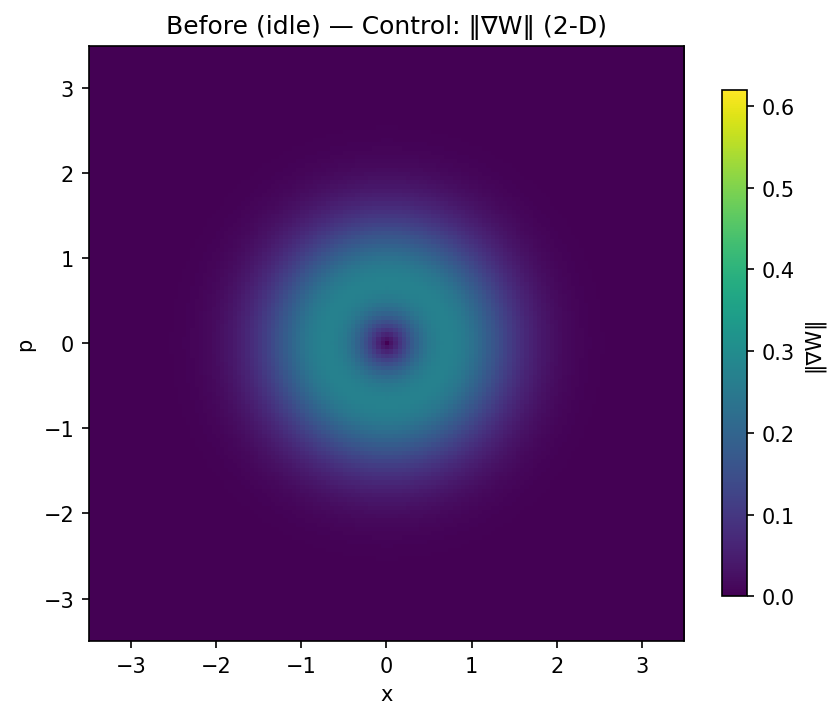

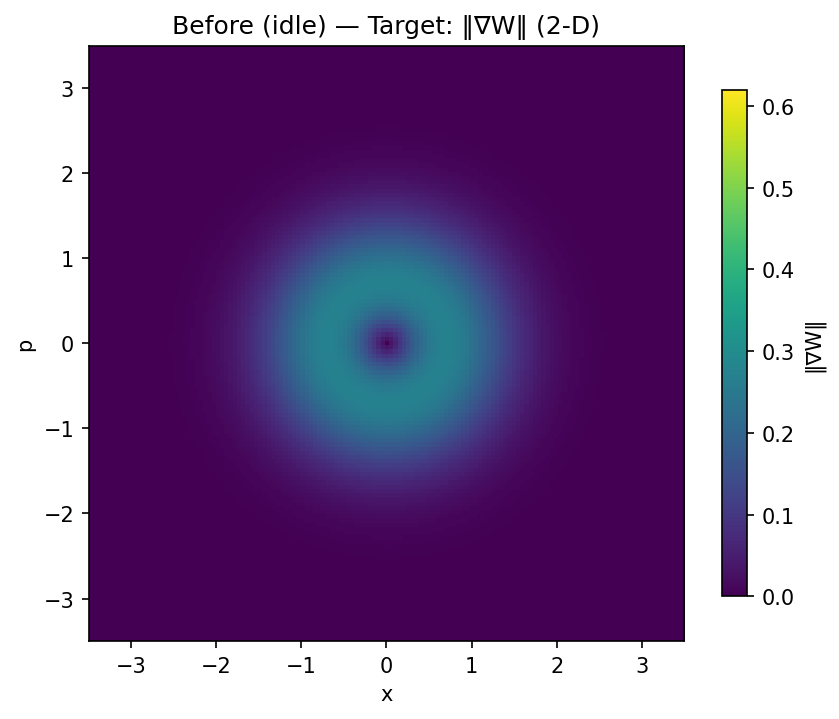

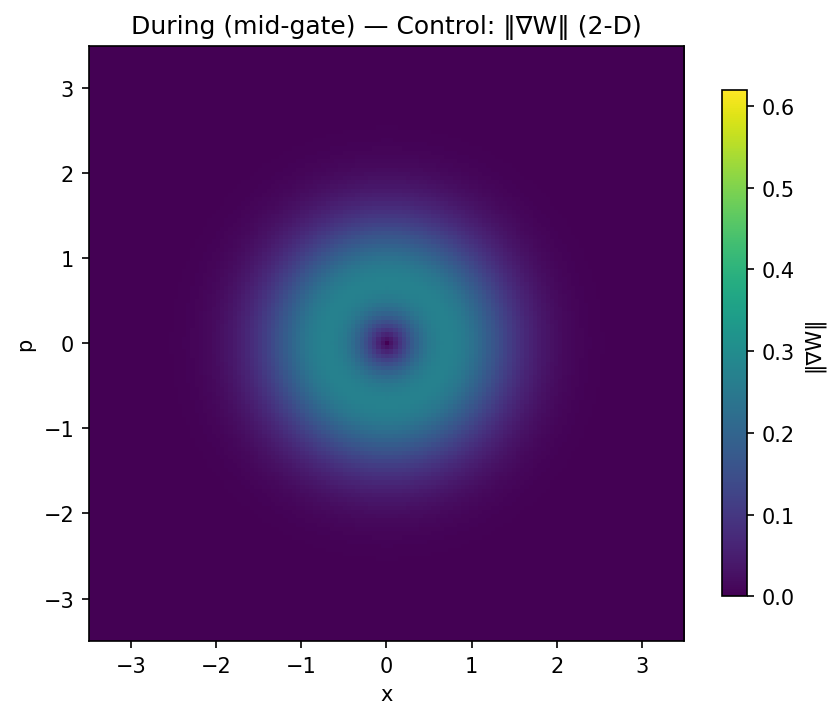

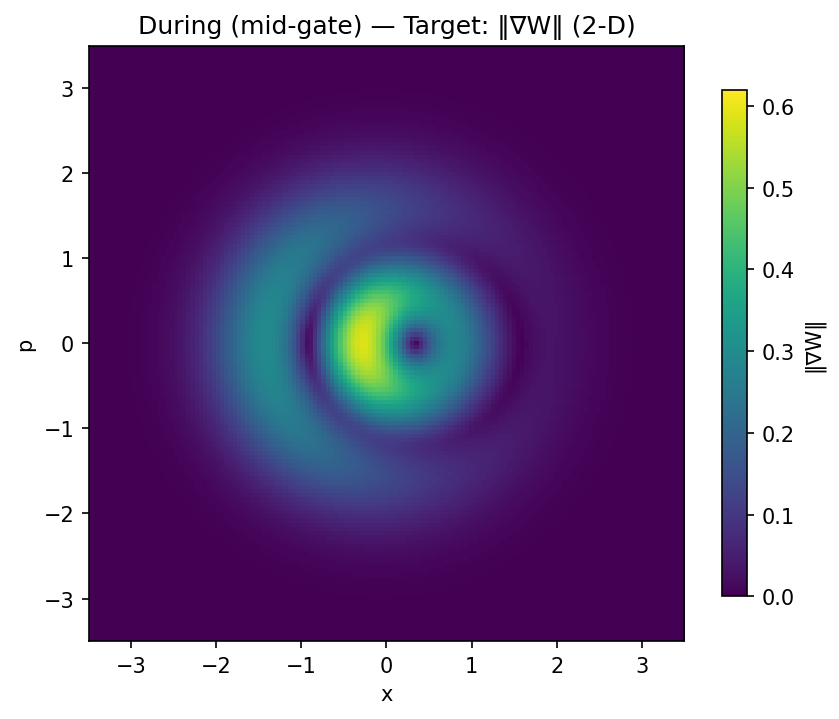

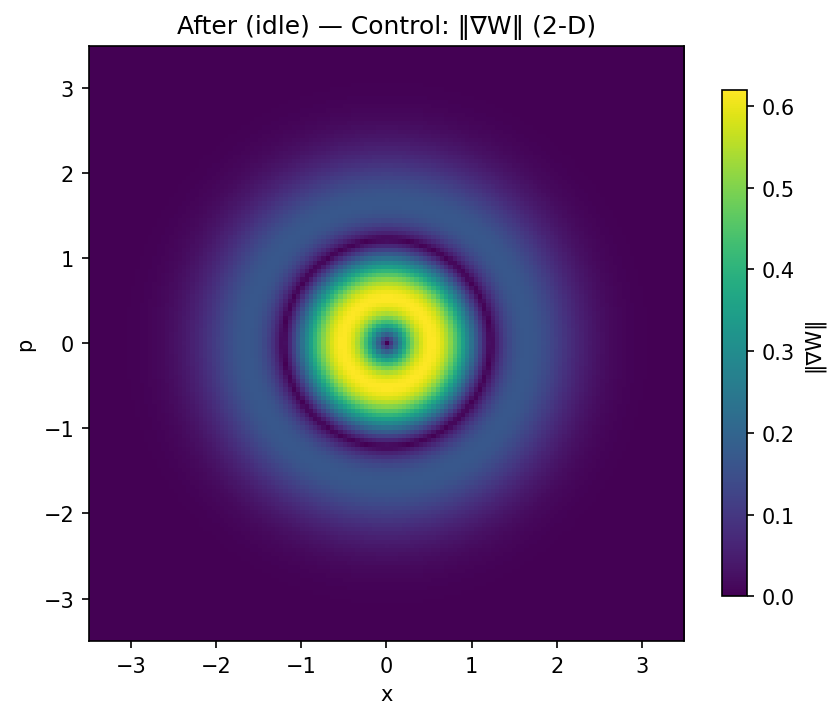

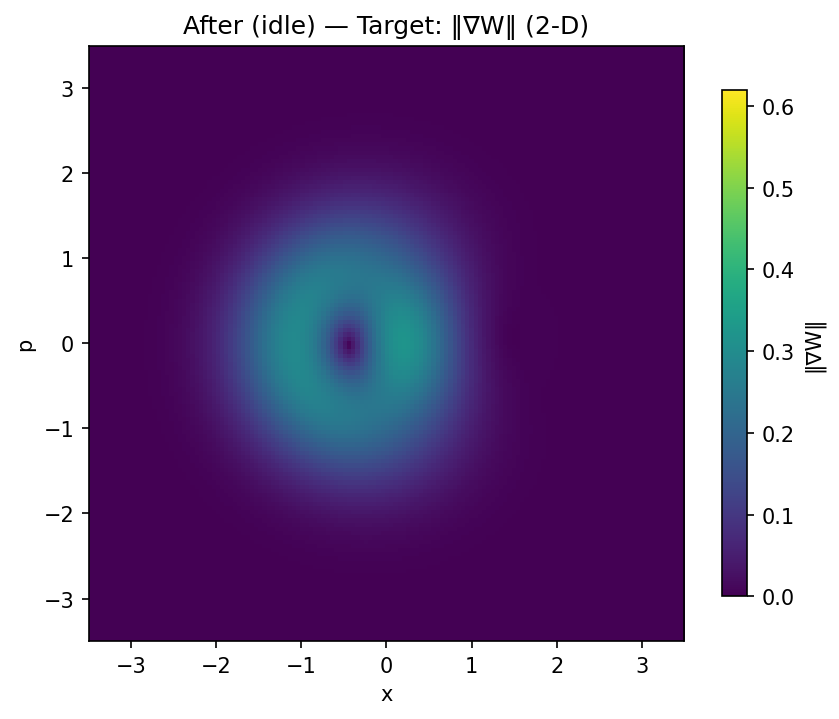

In [29]:
#@title 5C) 2-D ‖∇W‖ heatmaps (global scale + legend)
def plot_grad_2d(x, G, title, norm, cmap):
    extent = [x[0], x[-1], x[0], x[-1]]
    fig, ax = plt.subplots(figsize=(5.8, 4.8))
    im = ax.imshow(
        G.T, origin="lower", extent=extent, aspect="equal",
        cmap=cmap, norm=norm, interpolation="nearest"
    )
    ax.set_xlabel("x"); ax.set_ylabel("p"); ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, shrink=0.85, pad=0.05)
    cbar.set_label("‖∇W‖")
    plt.tight_layout(); plt.show()

for tag in snapshots.keys():
    Gc, Gt = G_store[tag]
    plot_grad_2d(xvec, Gc, make_title(tag, "Control: ‖∇W‖ (2-D)"), grad_norm, grad_cmap)
    plot_grad_2d(xvec, Gt, make_title(tag, "Target: ‖∇W‖ (2-D)"),  grad_norm, grad_cmap)

In [36]:
#@title Install cmcrameri (perceptually-uniform scientific colormaps)
!pip -q install cmcrameri

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.4/277.4 kB 4.1 MB/s eta 0:00:00


In [38]:
#@title Define colormaps and a color-blind–safe categorical palette
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

try:
    import cmcrameri.cm as cmc   # Scientific colour maps (vik, batlow, etc.)
    WIGNER_CMAP = cmc.vik       # perceptually uniform, diverging (blue–white–red)
    GRAD_CMAP   = cmc.batlow    # perceptually uniform, sequential
except Exception:
    WIGNER_CMAP = "RdBu_r"      # fallback: standard diverging with zero≈white
    GRAD_CMAP   = "cividis"     # fallback: CVD-friendly, perceptually uniform

# Okabe–Ito categorical colors (color-universal design)
OI = {
    "blue":   "#0072B2",
    "orange": "#E69F00",
    "sky":    "#56B4E9",
    "green":  "#009E73",
    "yellow": "#F0E442",
    "vermil": "#D55E00",
    "purple": "#CC79A7",
    "black":  "#000000",
}

/tmp/ipython-input-1453503691.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


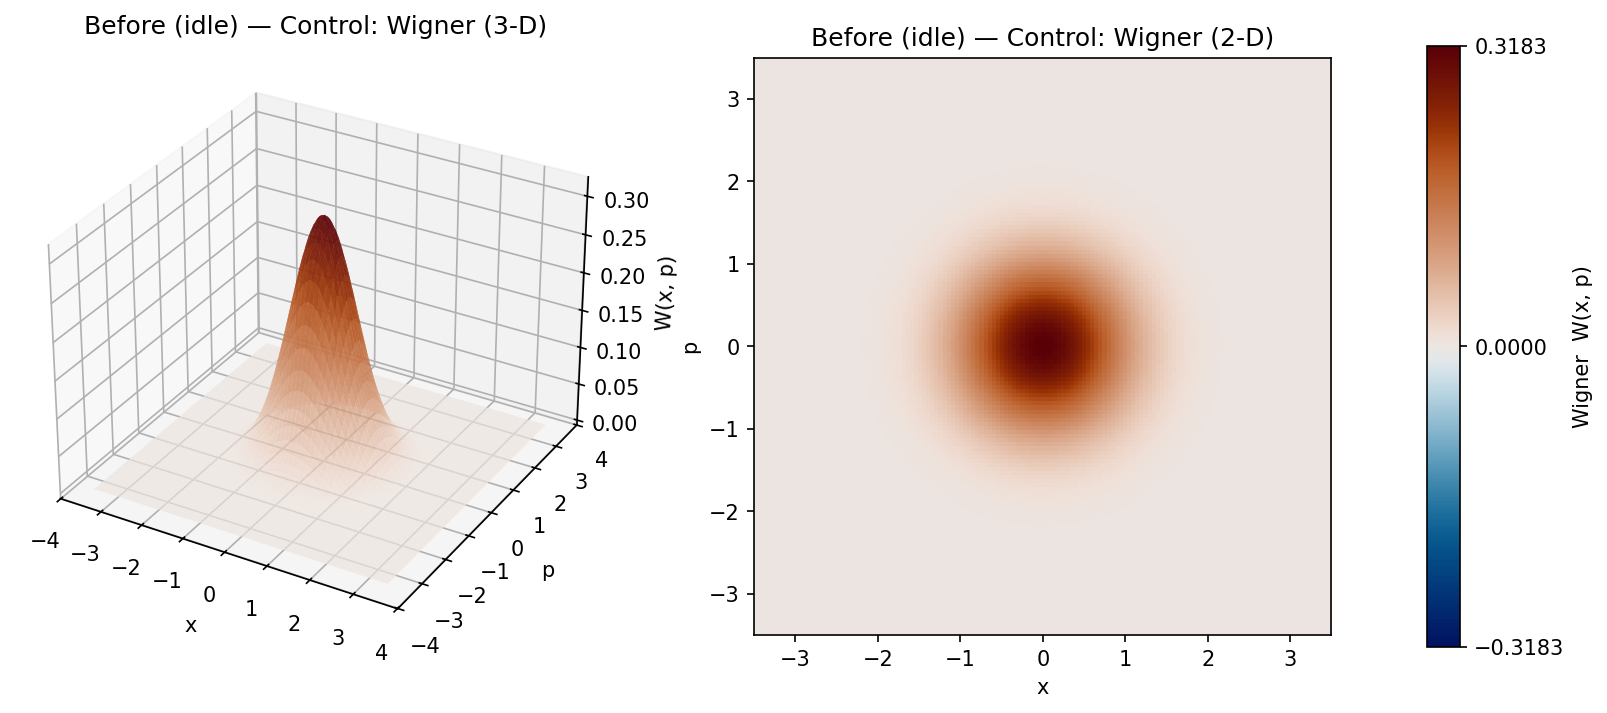

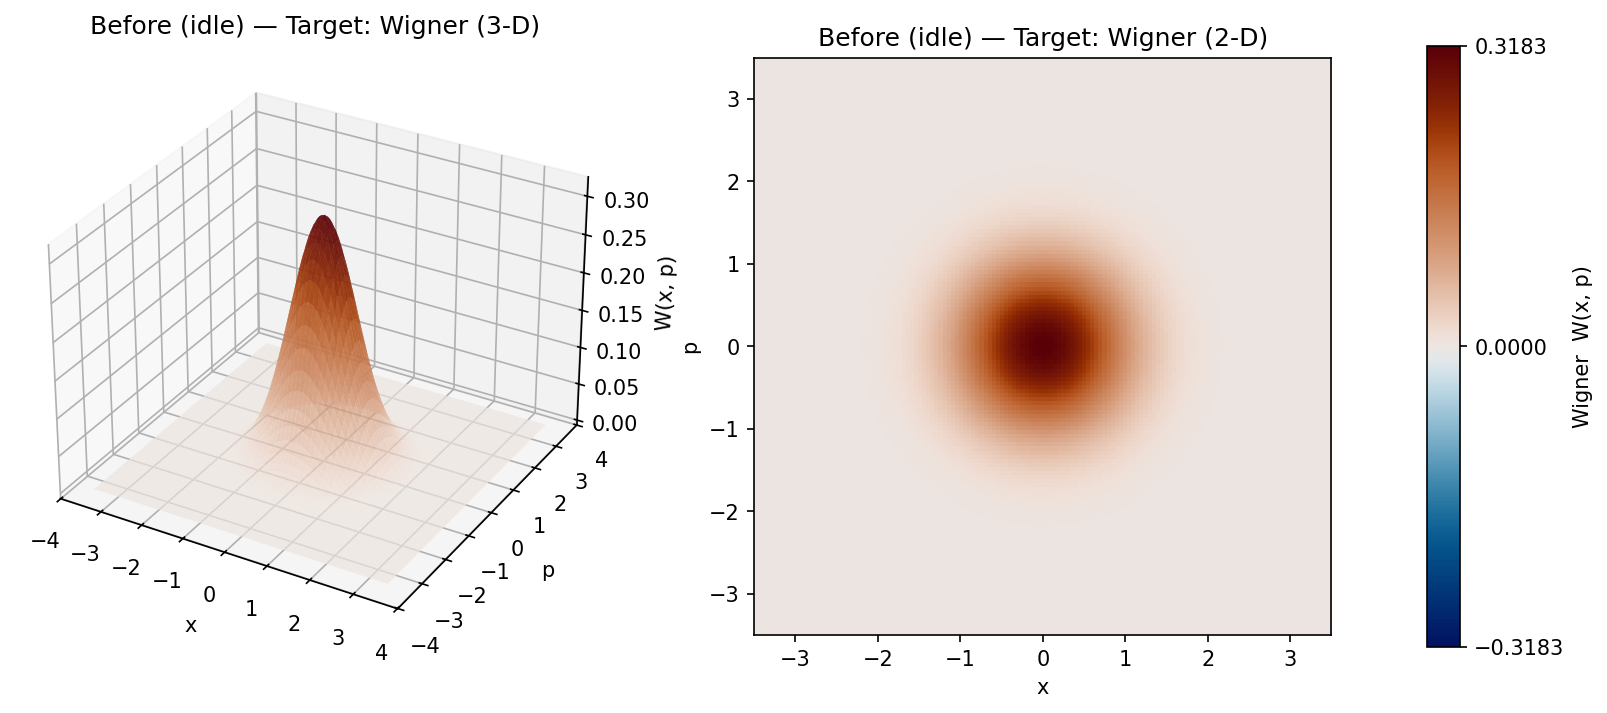

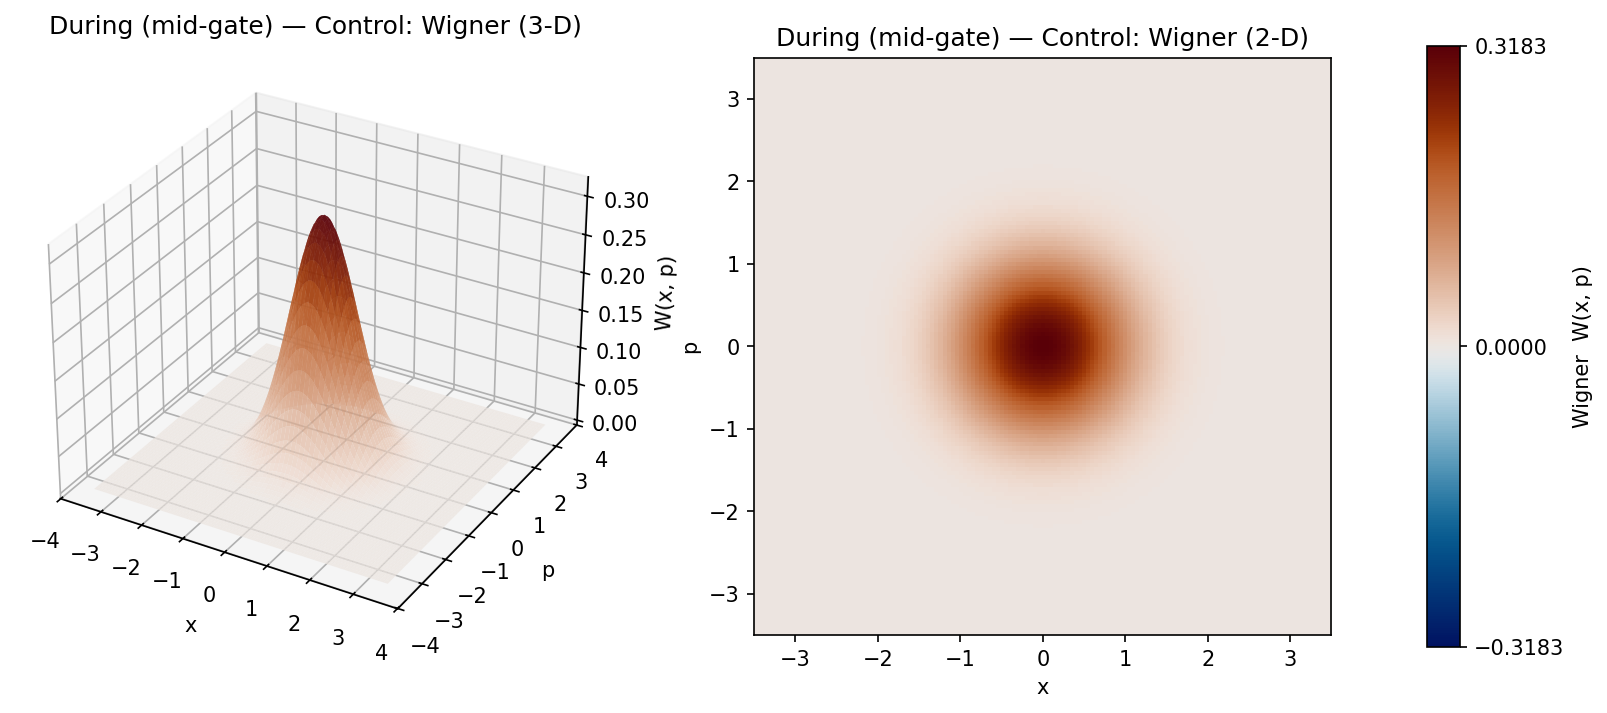

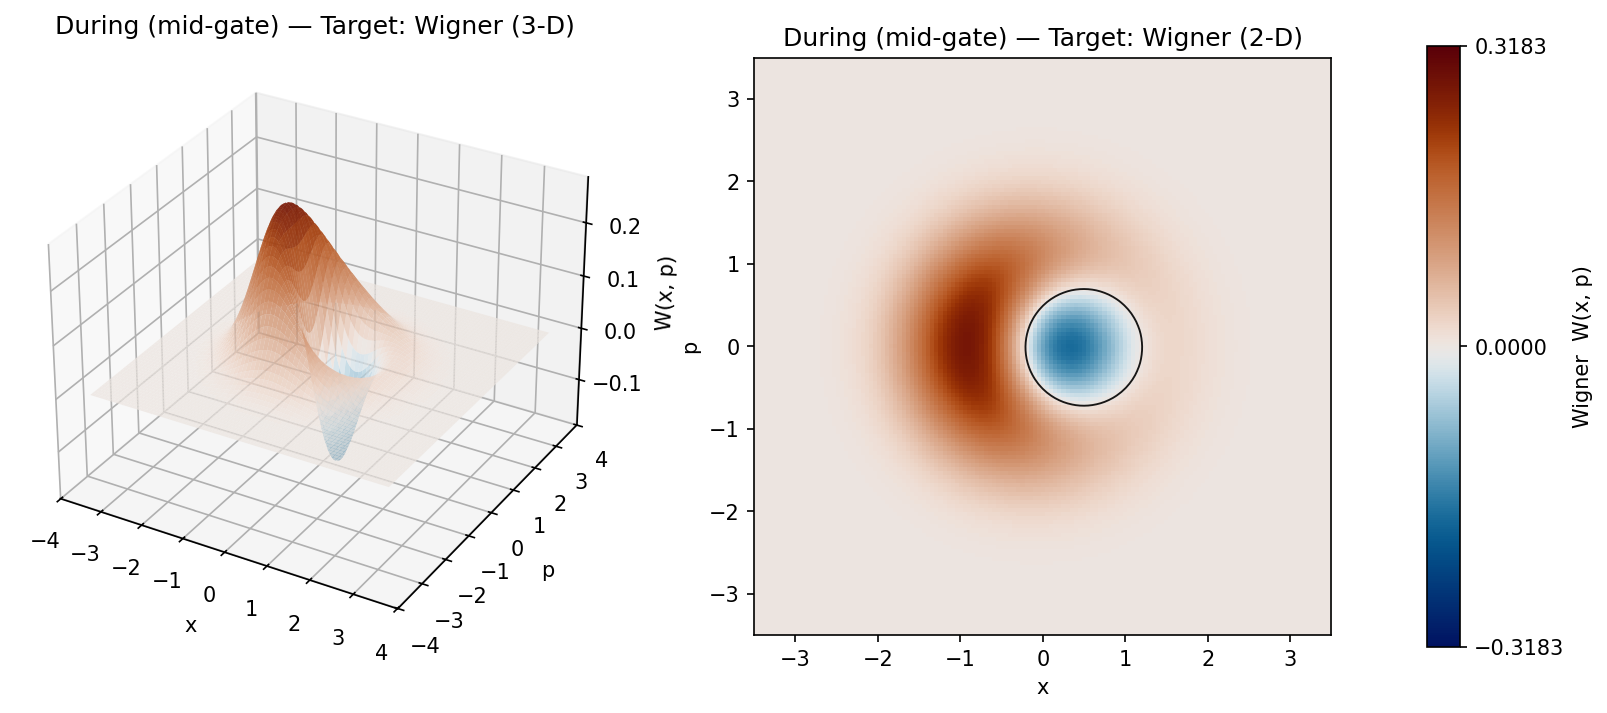

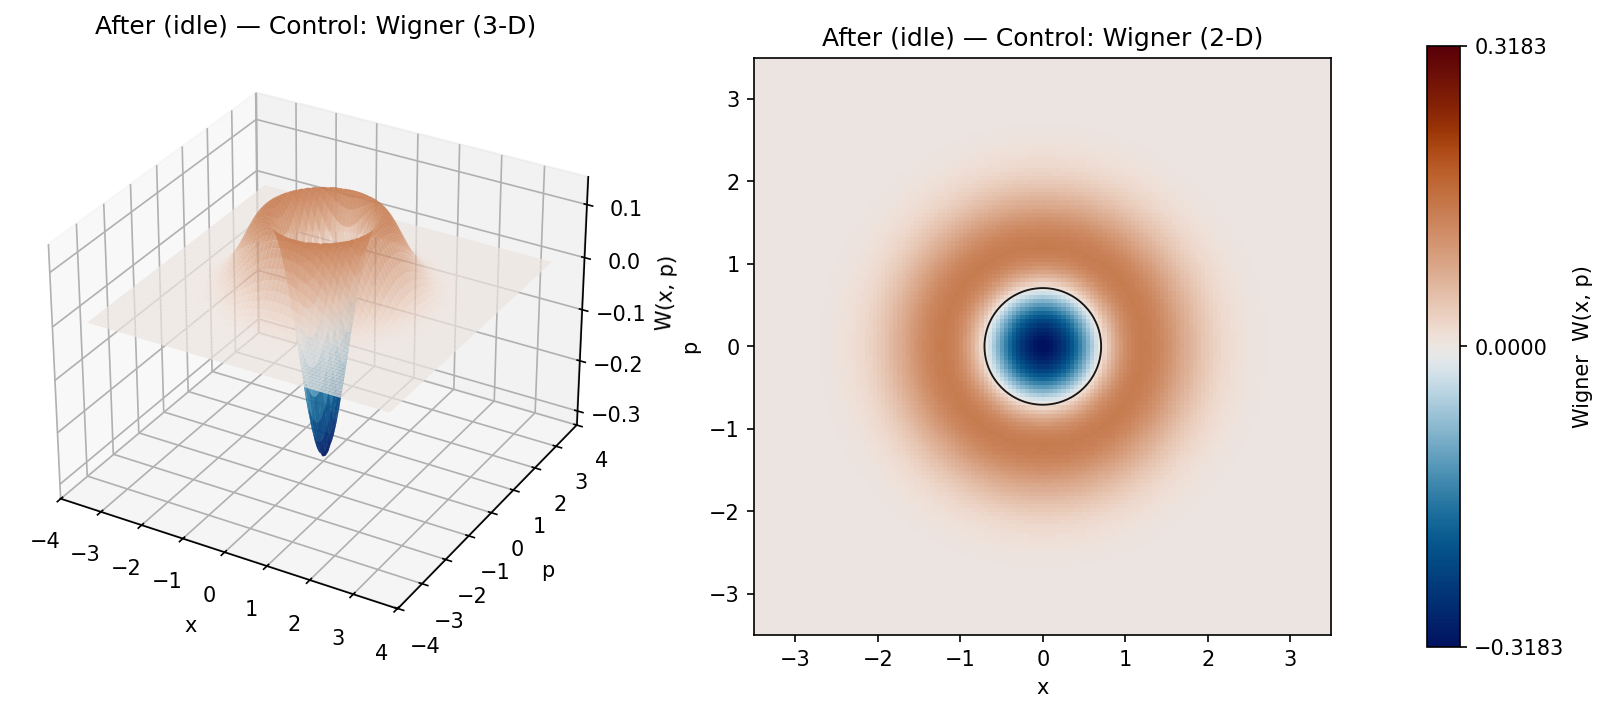

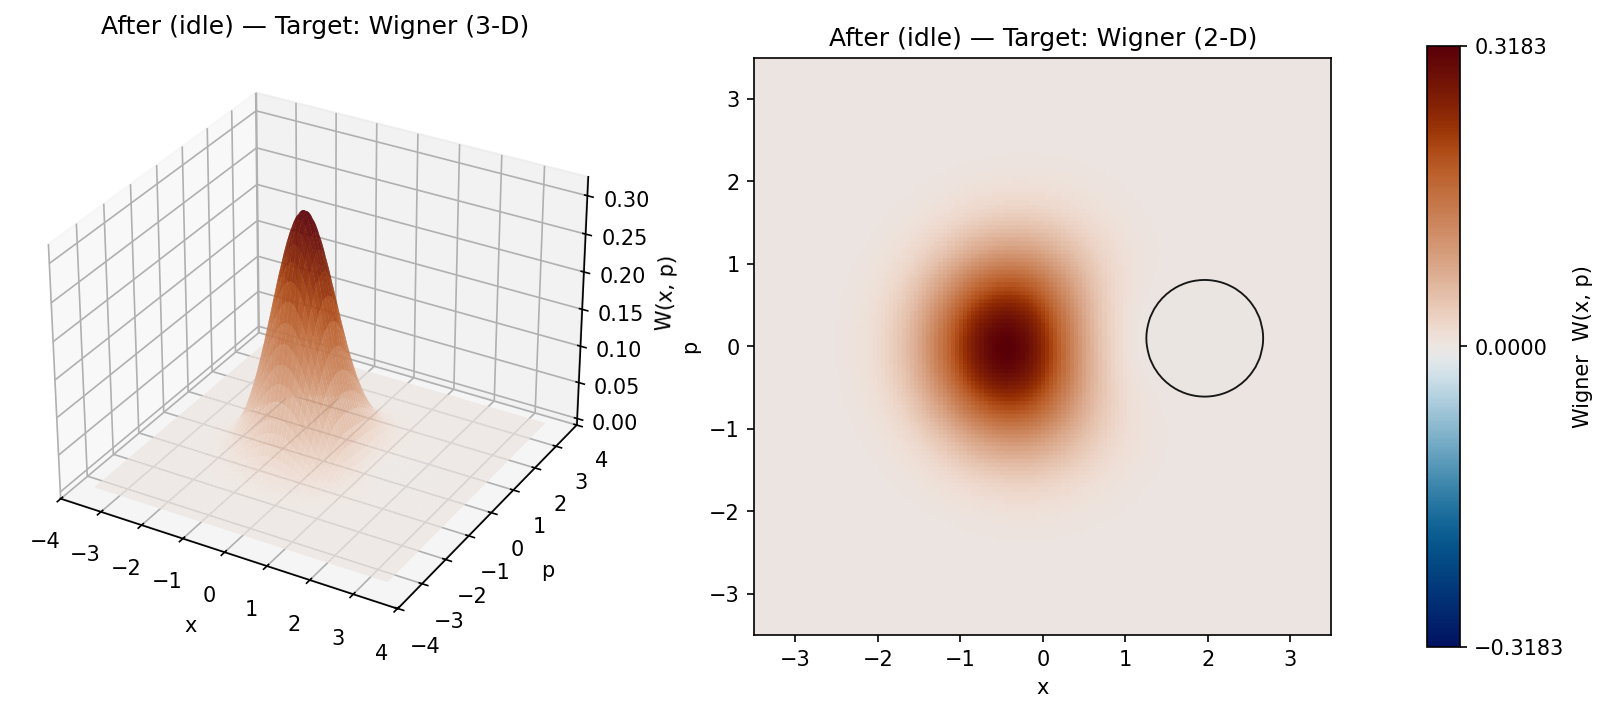

In [42]:
#@title 5E+) Accurate-colors Wigner pairs (3-D + 2-D, shared legend on far right)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# --- Robust colormap picks (perceptually uniform, CVD-friendly) ---
try:
    import cmcrameri.cm as cmc     # Scientific colour maps
    WIGNER_CMAP = cmc.vik          # diverging, zero≈neutral (white/very light)
except Exception:
    WIGNER_CMAP = "RdBu_r"         # safe fallback from Matplotlib

def plot_wigner_pair_right_cbar(x, Z, titles, norm, cmap, alpha=0.75, add_zero_contour=True):
    """
    3D Wigner surface (left) + 2D Wigner heatmap (middle) with ONE shared
    colorbar on the FAR RIGHT. Uses a global, zero-centered norm for consistency.
    """
    x = np.asarray(x)
    Xg, Pg = np.meshgrid(x, x, indexing="ij")

    # accept str or Colormap
    cmap_obj = plt.get_cmap(cmap) if isinstance(cmap, str) else cmap

    fig = plt.figure(figsize=(12.8, 5.2), constrained_layout=False)
    gs  = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[1.25, 1.05, 0.06], wspace=0.22)

    ax3d = fig.add_subplot(gs[0, 0], projection="3d")
    ax2d = fig.add_subplot(gs[0, 1])
    cax  = fig.add_subplot(gs[0, 2])  # rightmost legend axis

    # ---- Left: 3D surface with exact color mapping (no lighting distortion) ----
    facecolors = cmap_obj(norm(Z))
    facecolors[..., -1] = alpha
    ax3d.plot_surface(Xg, Pg, Z, facecolors=facecolors,
                      rstride=2, cstride=2, linewidth=0.0,
                      antialiased=True, shade=False)   # shade=False preserves colors
    ax3d.set_xlabel("x"); ax3d.set_ylabel("p"); ax3d.set_zlabel("W(x, p)")
    ax3d.set_title(titles[0])

    # ---- Middle: 2D heatmap with identical norm/cmap ----
    extent = [x[0], x[-1], x[0], x[-1]]
    im = ax2d.imshow(Z.T, origin="lower", extent=extent, aspect="equal",
                     cmap=cmap_obj, norm=norm, interpolation="nearest")
    if add_zero_contour and isinstance(norm, TwoSlopeNorm):
        try:
            ax2d.contour(x, x, Z.T, levels=[0.0], colors="k", linewidths=0.9, alpha=0.9)
        except Exception:
            pass
    ax2d.set_xlabel("x"); ax2d.set_ylabel("p")
    ax2d.set_title(titles[1])

    # ---- Right: shared colorbar (legend) with symmetric ticks ----
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    sm.set_array(Z)
    cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
    cbar.set_label("Wigner  W(x, p)")
    if isinstance(norm, TwoSlopeNorm):
        vmax = max(abs(norm.vmin), abs(norm.vmax))
        cbar.set_ticks([-vmax, 0.0, vmax])

    plt.tight_layout()
    plt.show()

# ---- Recompute global symmetric Wigner scale (keeps colors consistent across panels) ----
xmax, nx = 3.5, 141
xvec = np.linspace(-xmax, xmax, nx)

W_abs_max = 0.0
for tag, rho2 in snapshots.items():
    rho_c, rho_t = reduced_qubit_states(rho2)
    Wc, _ = wigner_and_grad(embed_into_oscillator(rho_c, n_levels=10), xvec)
    Wt, _ = wigner_and_grad(embed_into_oscillator(rho_t, n_levels=10), xvec)
    W_abs_max = max(W_abs_max, np.max(np.abs(Wc)), np.max(np.abs(Wt)))

# Zero-centered, symmetric normalization for signed Wigner
wigner_norm = TwoSlopeNorm(vmin=-W_abs_max, vcenter=0.0, vmax=W_abs_max)

# ---- Render Control & Target for each snapshot (3D + 2D with legend on far right) ----
for tag in snapshots.keys():
    Wc, Wt = W_store[tag] if tag in W_store else (
        wigner_and_grad(embed_into_oscillator(reduced_qubit_states(snapshots[tag])[0], n_levels=10), xvec)[0],
        wigner_and_grad(embed_into_oscillator(reduced_qubit_states(snapshots[tag])[1], n_levels=10), xvec)[0]
    )

    plot_wigner_pair_right_cbar(
        xvec, Wc,
        (make_title(tag, "Control: Wigner (3-D)"),
         make_title(tag, "Control: Wigner (2-D)")),
        wigner_norm, WIGNER_CMAP, alpha=0.75
    )
    plot_wigner_pair_right_cbar(
        xvec, Wt,
        (make_title(tag, "Target: Wigner (3-D)"),
         make_title(tag, "Target: Wigner (2-D)")),
        wigner_norm, WIGNER_CMAP, alpha=0.75
    )

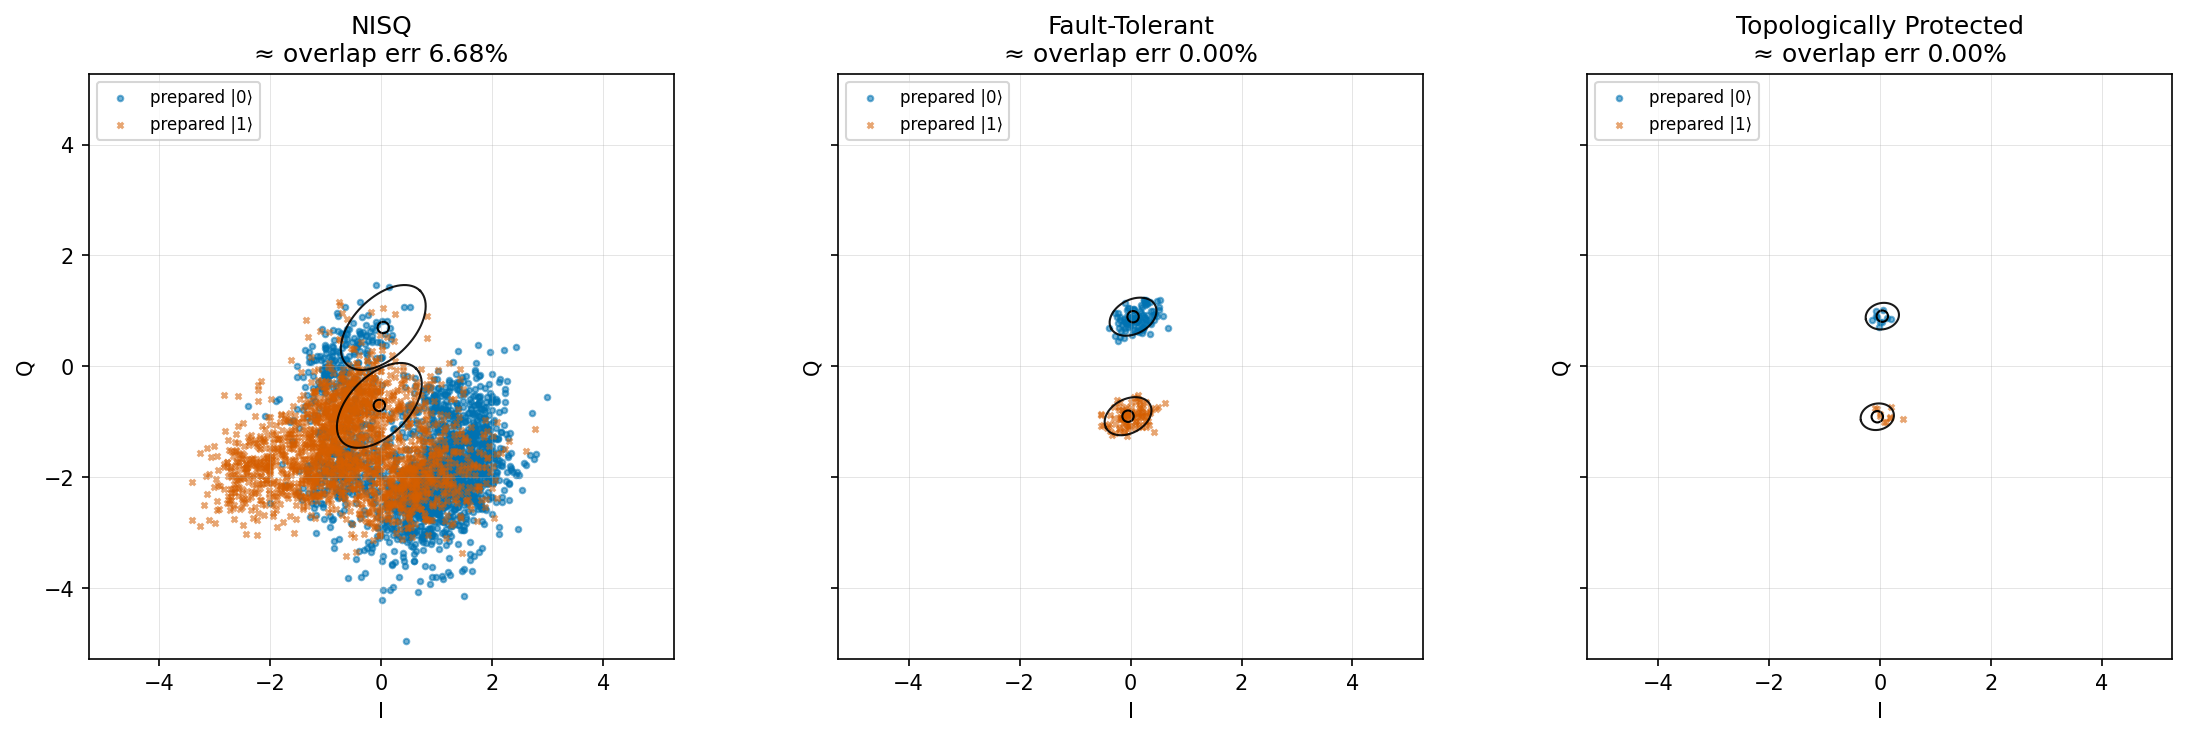

In [40]:
#@title 6C′) Use Okabe–Ito colors + shape encoding for I–Q clusters
import numpy as np
import matplotlib.pyplot as plt

palette_01 = {"0": OI["blue"], "1": OI["vermil"]}  # |0⟩ vs |1⟩
marker_01  = {"0": "o", "1": "x"}                  # shape redundancy

fig, axes = plt.subplots(1, 3, figsize=(15.2, 4.8), constrained_layout=True, sharex=True, sharey=True)
for ax, (name, prm) in zip(axes, regimes.items()):
    sx, sy = prm["sigma"]
    cov_rot  = cov_from_params(sx, sy, prm["corr"], prm["phi_deg"])
    evals, evecs = np.linalg.eigh(cov_rot)
    sigma_major = float(np.sqrt(evals.max()))
    d = prm["sep_sigma"] * sigma_major
    muA = -0.5 * d * u_dir; muB = +0.5 * d * u_dir
    I, Q, labels = simulate_iq(prm["shots"], np.stack([muA, muB]), cov_rot,
                               p_flip=prm["p_flip"], drift_sigma=prm["drift_sigma"],
                               seed=prm["seed"])

    for bit in (0, 1):
        m = labels == bit
        ax.scatter(I[m], Q[m], s=7, alpha=0.55,
                   c=palette_01[str(bit)], marker=marker_01[str(bit)],
                   label=f"prepared |{bit}⟩")

    # centers and 2σ ellipses
    for mu in (muA, muB):
        ax.scatter(mu[0], mu[1], s=30, facecolor='none', edgecolor=OI["black"])
        pts = ellipse_points(mu, cov_rot, ksigma=2.0, n=240)
        ax.plot(pts[:,0], pts[:,1], color=OI["black"], linewidth=1.0, alpha=0.9)

    from math import erfc
    perr = 0.5 * erfc(d/(2*np.sqrt(2)*sigma_major))
    ax.set_title(f"{name}\n≈ overlap err {perr*100:.2f}%")
    ax.set_xlabel("I"); ax.set_ylabel("Q"); ax.set_aspect("equal")
    ax.grid(True, linewidth=0.45, alpha=0.35)
    ax.legend(loc="upper left", fontsize=8, frameon=True)

# common symmetric limits
lims = []
for a in axes: lims += list(a.get_xlim()) + list(a.get_ylim())
L = max(map(abs, lims))
for a in axes: a.set_xlim(-L, L); a.set_ylim(-L, L)
plt.show()


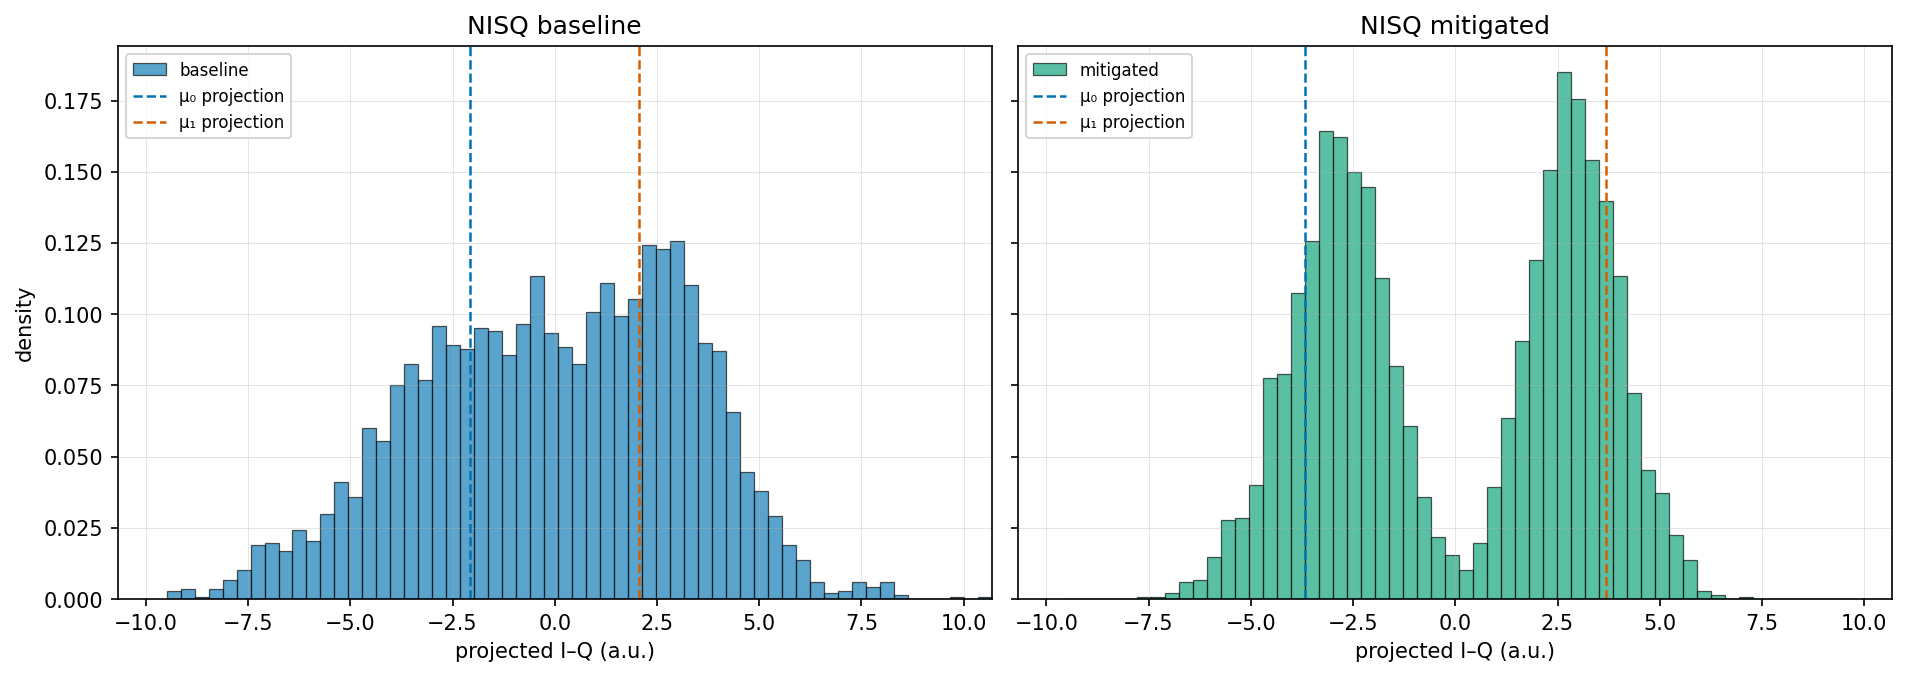

In [45]:
#@title 6C″) Accurate colors for whitened LDA histograms (Okabe–Ito + redundancy)
import numpy as np
import matplotlib.pyplot as plt

# Okabe–Ito (color-universal design) palette
OI = {
    "blue":   "#0072B2",
    "orange": "#E69F00",
    "sky":    "#56B4E9",
    "green":  "#009E73",
    "yellow": "#F0E442",
    "vermil": "#D55E00",
    "purple": "#CC79A7",
    "black":  "#000000",
}

# Use the same bin edges for both panels so densities are comparable
lo = min(np.min(s0), np.min(s1))
hi = max(np.max(s0), np.max(s1))
bins = np.linspace(lo, hi, 60)

fig, axes = plt.subplots(1, 2, figsize=(12.6, 4.4), constrained_layout=True, sharey=True)

# --- Baseline (left) ---
ax = axes[0]
ax.hist(s0, bins=bins, density=True,
        color=OI["blue"], alpha=0.65,
        edgecolor=OI["black"], linewidth=0.6,
        label="baseline")
# Projected class centers at ±d/2 (whitened LDA)
ax.axvline(-0.5*d0_w, color=OI["blue"],   linestyle="--", linewidth=1.2, label="μ₀ projection")
ax.axvline(+0.5*d0_w, color=OI["vermil"], linestyle="--", linewidth=1.2, label="μ₁ projection")

ax.set_title("NISQ baseline")
ax.set_xlabel("projected I–Q (a.u.)")
ax.set_ylabel("density")
ax.grid(True, linewidth=0.45, alpha=0.35)
ax.legend(loc="upper left", fontsize=8, frameon=True)

# --- Mitigated (right) ---
ax = axes[1]
ax.hist(s1, bins=bins, density=True,
        color=OI["green"], alpha=0.65,
        edgecolor=OI["black"], linewidth=0.6,
        label="mitigated")
ax.axvline(-0.5*d1_w, color=OI["blue"],   linestyle="--", linewidth=1.2, label="μ₀ projection")
ax.axvline(+0.5*d1_w, color=OI["vermil"], linestyle="--", linewidth=1.2, label="μ₁ projection")

ax.set_title("NISQ mitigated")
ax.set_xlabel("projected I–Q (a.u.)")
ax.grid(True, linewidth=0.45, alpha=0.35)
ax.legend(loc="upper left", fontsize=8, frameon=True)

# Symmetric x-limits so colors and geometry read consistently
xlim = max(abs(lo), abs(hi))
for a in axes:
    a.set_xlim(-xlim, xlim)

plt.show()

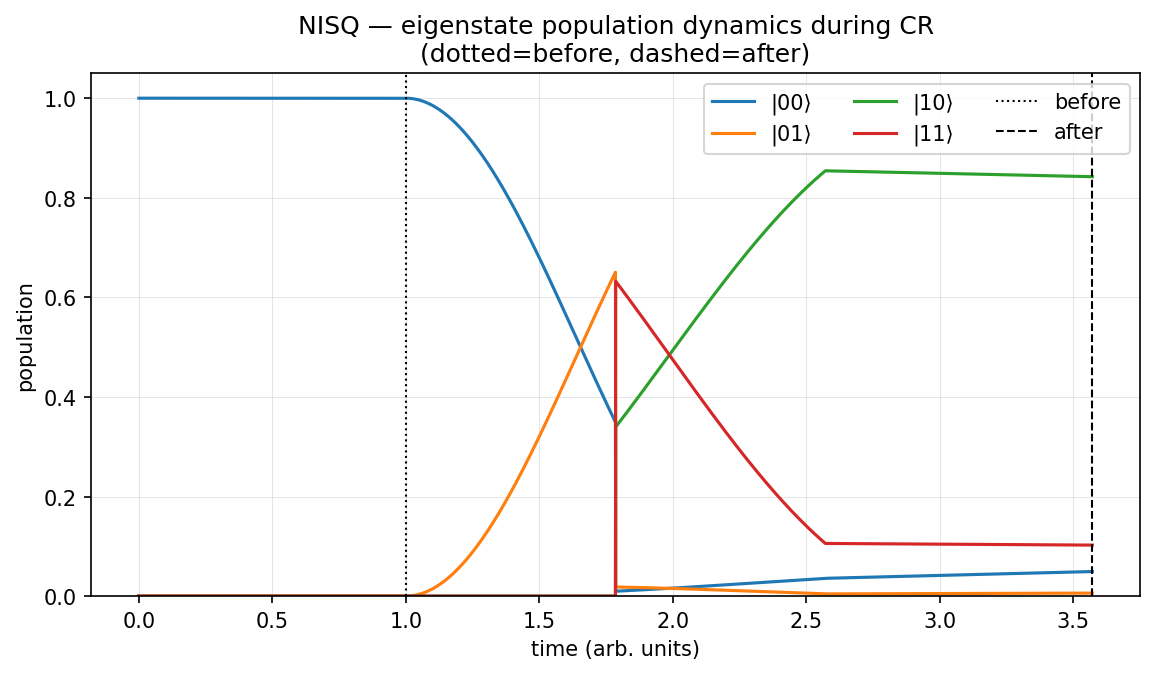

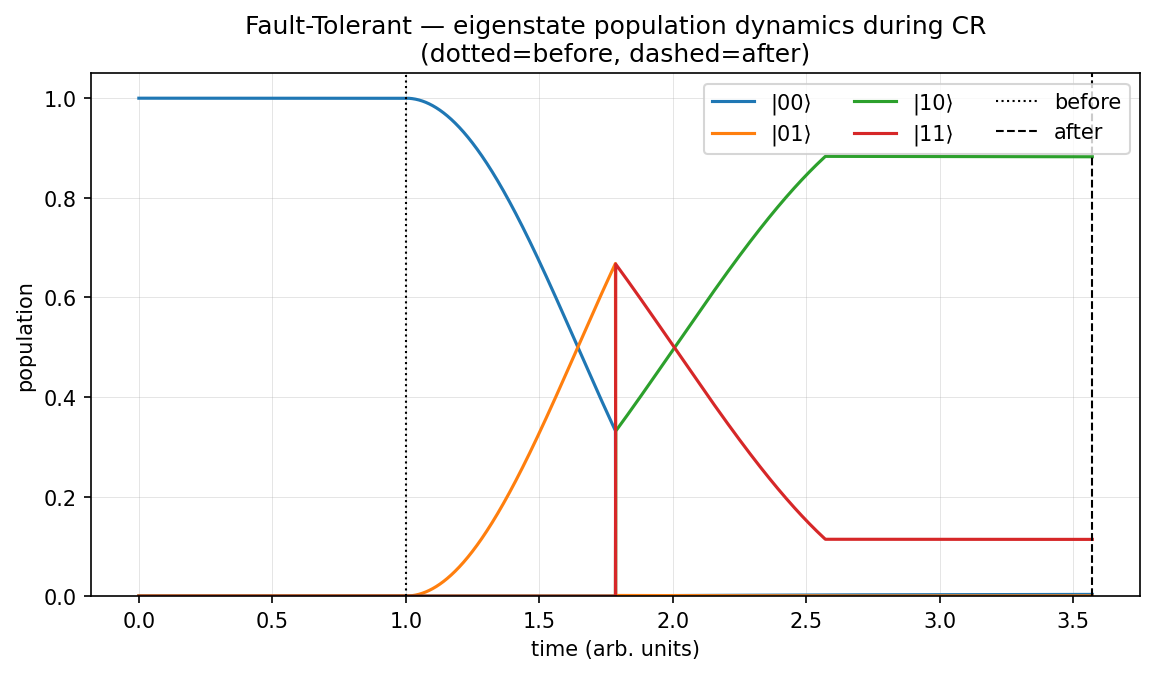

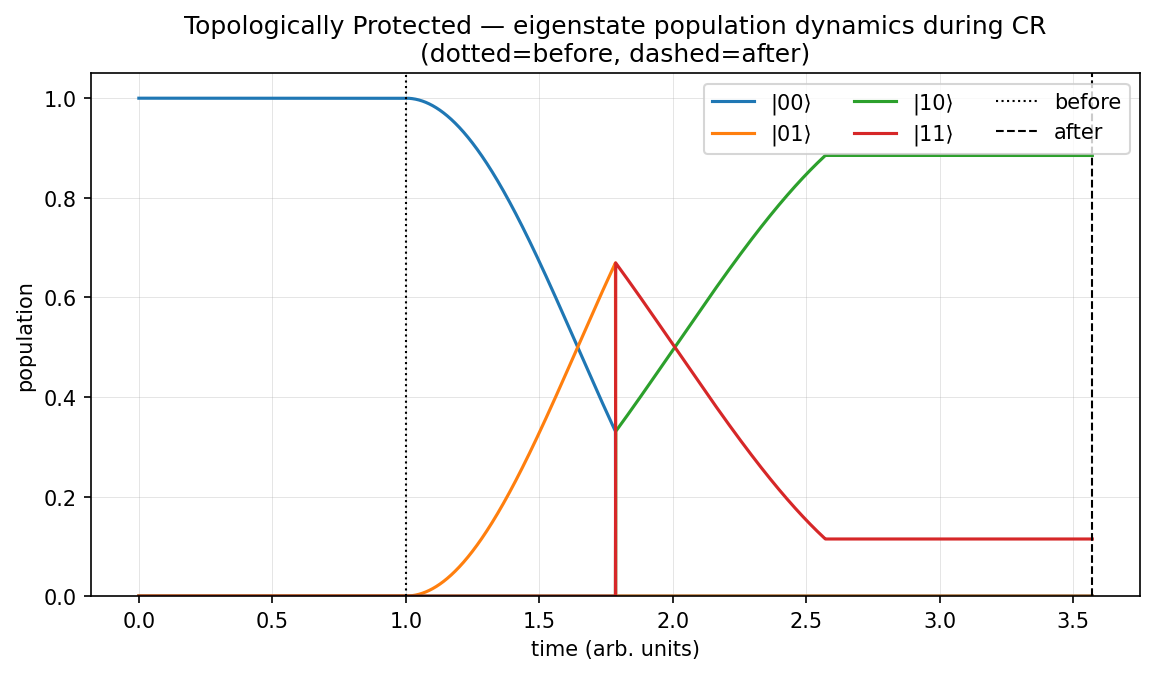


=== NISQ — BEFORE (numeric density matrix in computational basis) ===


/tmp/ipython-input-265814393.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda z: f"{z.real:+.4f}{z.imag:+.4f}i")


|00⟩             |01⟩             |10⟩             |11⟩
|00⟩  +1.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|01⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|10⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|11⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i

/tmp/ipython-input-265814393.py:91: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


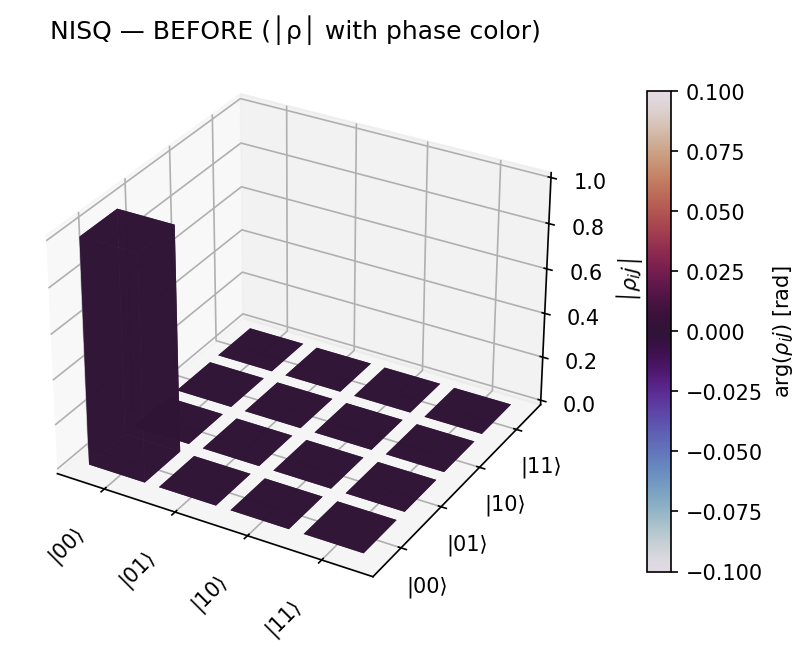

=== NISQ — AFTER (numeric density matrix in computational basis) ===


/tmp/ipython-input-265814393.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda z: f"{z.real:+.4f}{z.imag:+.4f}i")


|00⟩             |01⟩             |10⟩             |11⟩
|00⟩  +0.0493+0.0000i  -0.0008+0.0156i  +0.0000+0.0000i  +0.0000+0.0000i
|01⟩  -0.0008-0.0156i  +0.0060+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|10⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.8423+0.0000i  -0.0134+0.2669i
|11⟩  +0.0000+0.0000i  +0.0000+0.0000i  -0.0134-0.2669i  +0.1024+0.0000i

/tmp/ipython-input-265814393.py:91: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


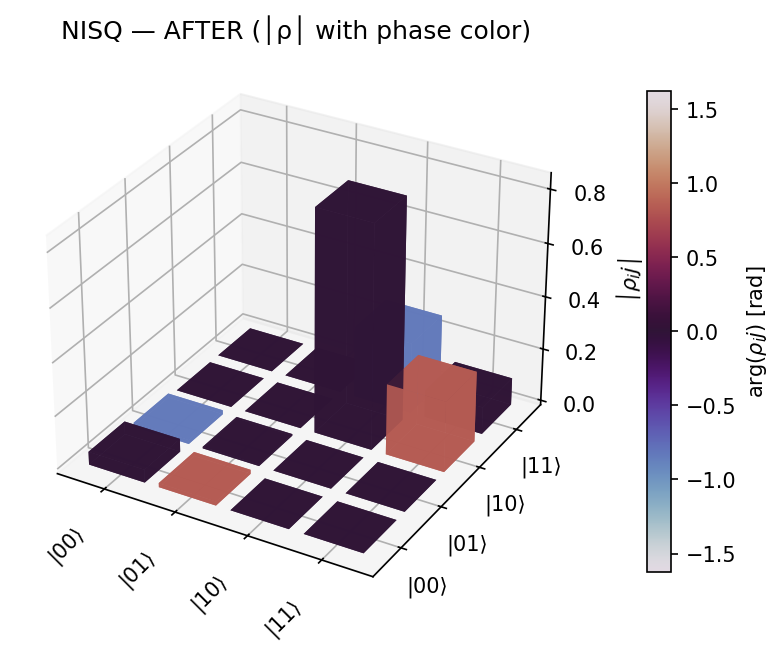


=== Fault-Tolerant — BEFORE (numeric density matrix in computational basis) ===


/tmp/ipython-input-265814393.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda z: f"{z.real:+.4f}{z.imag:+.4f}i")


|00⟩             |01⟩             |10⟩             |11⟩
|00⟩  +1.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|01⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|10⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|11⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i

/tmp/ipython-input-265814393.py:91: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


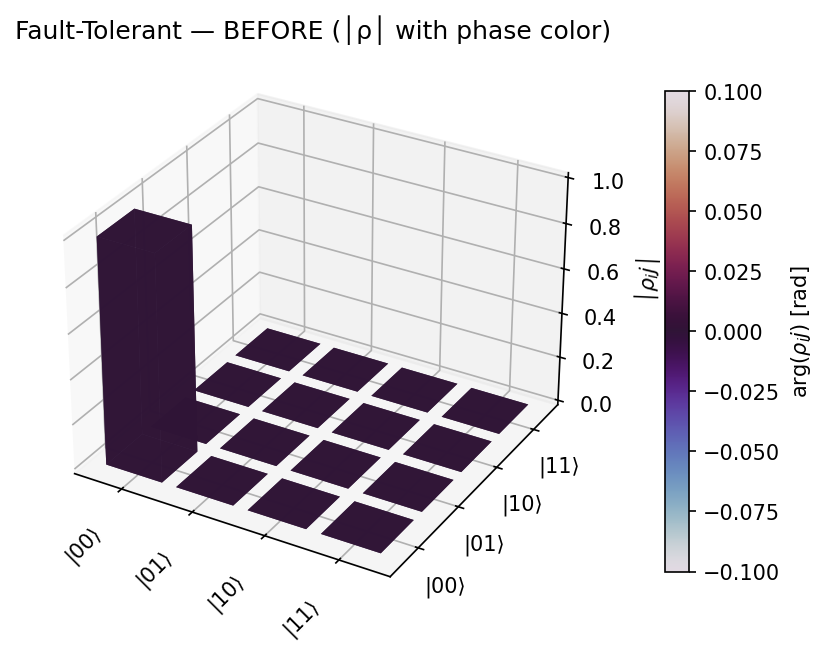

=== Fault-Tolerant — AFTER (numeric density matrix in computational basis) ===


/tmp/ipython-input-265814393.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda z: f"{z.real:+.4f}{z.imag:+.4f}i")


|00⟩             |01⟩             |10⟩             |11⟩
|00⟩  +0.0034+0.0000i  -0.0001+0.0012i  +0.0000+0.0000i  +0.0000+0.0000i
|01⟩  -0.0001-0.0012i  +0.0004+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|10⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.8824+0.0000i  -0.0158+0.3153i
|11⟩  +0.0000+0.0000i  +0.0000+0.0000i  -0.0158-0.3153i  +0.1139+0.0000i

/tmp/ipython-input-265814393.py:91: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


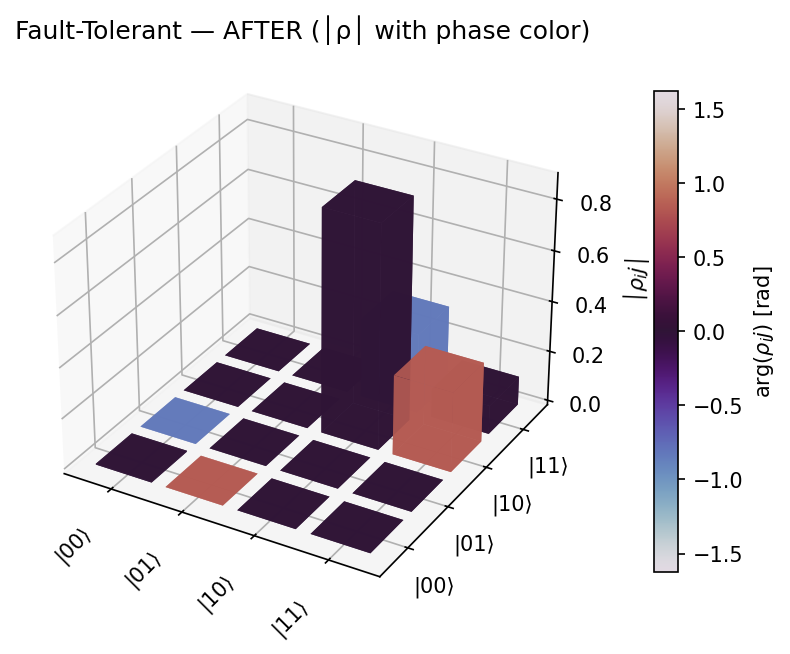


=== Topologically Protected — BEFORE (numeric density matrix in computational basis) ===


/tmp/ipython-input-265814393.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda z: f"{z.real:+.4f}{z.imag:+.4f}i")


|00⟩             |01⟩             |10⟩             |11⟩
|00⟩  +1.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|01⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|10⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|11⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i

/tmp/ipython-input-265814393.py:91: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


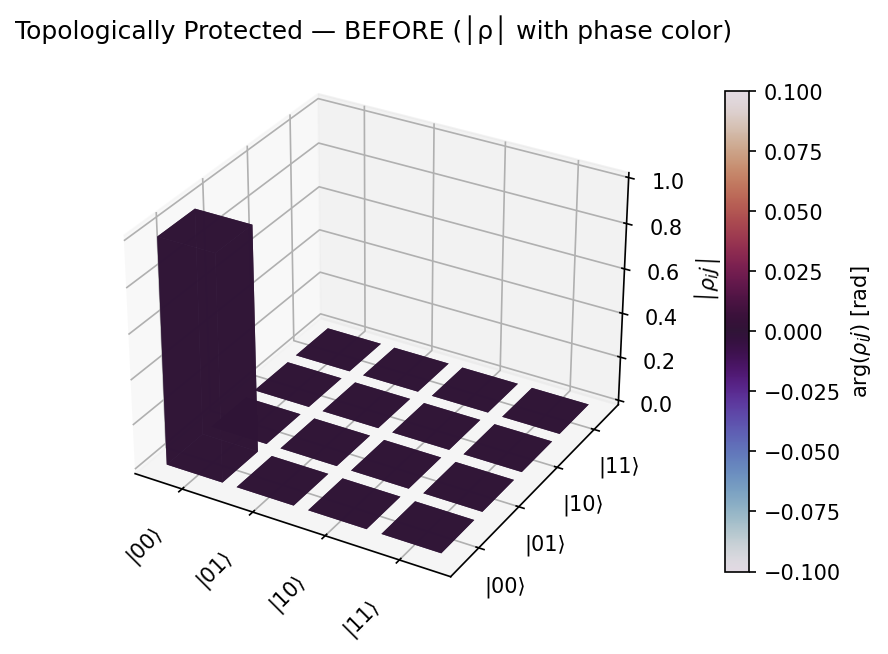

=== Topologically Protected — AFTER (numeric density matrix in computational basis) ===


/tmp/ipython-input-265814393.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda z: f"{z.real:+.4f}{z.imag:+.4f}i")


|00⟩             |01⟩             |10⟩             |11⟩
|00⟩  +0.0003+0.0000i  -0.0000+0.0001i  +0.0000+0.0000i  +0.0000+0.0000i
|01⟩  -0.0000-0.0001i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|10⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.8850+0.0000i  -0.0160+0.3180i
|11⟩  +0.0000+0.0000i  +0.0000+0.0000i  -0.0160-0.3180i  +0.1146+0.0000i

/tmp/ipython-input-265814393.py:91: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


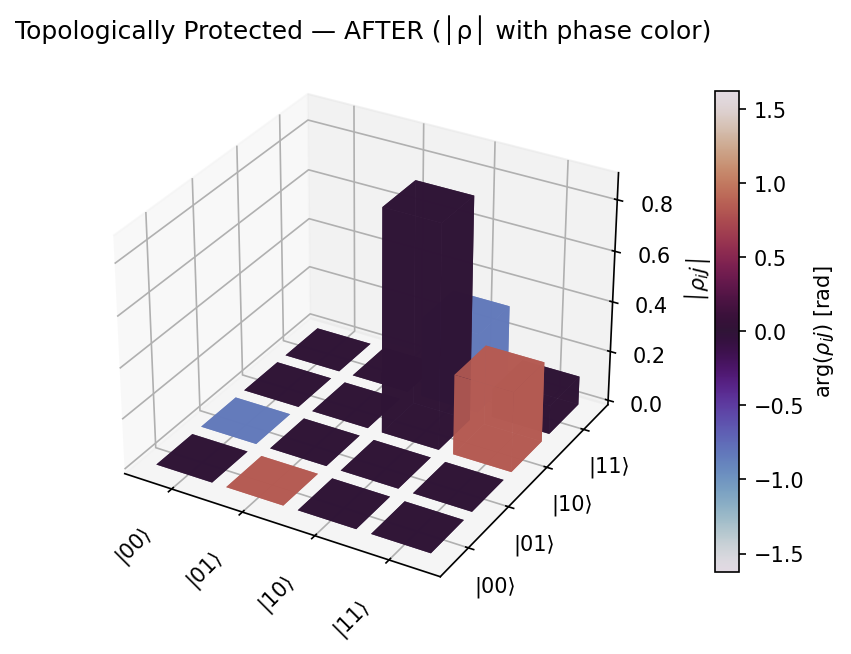

In [63]:
#@title 8) Density matrices + eigenstate populations (before/after CR) for three regimes
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import qutip as qt

# --- Pull the ideal snapshots you already built earlier ---
rho_before_ideal = rho_all[sim["idx_before"]]   # |00> at end of pre-idle
rho_after_ideal  = rho_all[sim["idx_after"]]    # state at end of post-idle
times = np.asarray(sim["times"])
tau   = float(sim["tau"])  # one full CR (ZX) angle-integral duration

# ---------- Single-qubit channels (Kraus) ----------
def amplitude_damping_kraus(p):
    """Kraus ops for amplitude damping with probability p = 1 - exp(-t/T1)."""
    p = float(np.clip(p, 0.0, 1.0))
    E0 = qt.Qobj(np.array([[1.0, 0.0],
                           [0.0, np.sqrt(1.0 - p)]]), dims=[[2],[2]])
    E1 = qt.Qobj(np.array([[0.0, np.sqrt(p)],
                           [0.0, 0.0]]), dims=[[2],[2]])
    return [E0, E1]

def phase_flip_kraus(p):
    """Pauli-Z dephasing (phase-flip) with coherence factor (1-2p) = exp(-t/Tphi)."""
    p = float(np.clip(p, 0.0, 0.5))
    I, Z = qt.qeye(2), qt.sigmaz()
    K0 = np.sqrt(1.0 - p) * I
    K1 = np.sqrt(p) * Z
    return [K0, K1]

def apply_kraus_on_qubit(rho, kraus_list, which):
    """Apply single-qubit Kraus channel to 'which' qubit of a 2-qubit density matrix."""
    Id = qt.qeye(2)
    out = qt.Qobj(np.zeros(rho.shape, dtype=complex), dims=rho.dims)
    for K in kraus_list:
        A = qt.tensor(K, Id) if which == 0 else qt.tensor(Id, K)
        out = out + A * rho * A.dag()
    return out

def noisy_map(rho, t, T1, Tphi):
    """Two-qubit local AD+dephasing at time t (relative to chosen T1,Tphi)."""
    pA = 1.0 - np.exp(-t / T1)           # amplitude damping
    pZ = 0.5 * (1.0 - np.exp(-t / Tphi)) # phase-flip with (1-2pZ) = e^{-t/Tphi}
    # control
    rho2 = apply_kraus_on_qubit(rho, amplitude_damping_kraus(pA), which=0)
    rho2 = apply_kraus_on_qubit(rho2, phase_flip_kraus(pZ), which=0)
    # target
    rho2 = apply_kraus_on_qubit(rho2, amplitude_damping_kraus(pA), which=1)
    rho2 = apply_kraus_on_qubit(rho2, phase_flip_kraus(pZ), which=1)
    return rho2

# ---------- Regime noise scales (relative to one CR-gate time τ) ----------
regime_noise = {
    "NISQ":                 {"T1":  40.0 * tau, "Tphi":  25.0 * tau},   # more damping/dephasing
    "Fault-Tolerant":       {"T1": 600.0 * tau, "Tphi": 600.0 * tau},   # much weaker noise
    "Topologically Protected":{"T1":6000.0 * tau, "Tphi":6000.0 * tau}, # almost ideal
}

# ---------- Helpers: tables and 3-D bar plots of ρ ----------
labels = ["|00⟩","|01⟩","|10⟩","|11⟩"]

def dm_table(rho):
    df = pd.DataFrame(rho.full(), index=labels, columns=labels)
    # show real+imag neatly
    return df.applymap(lambda z: f"{z.real:+.4f}{z.imag:+.4f}i")

def plot_dm_3d(rho, title):
    M = rho.full()
    mag = np.abs(M); phase = np.angle(M)
    nx, ny = M.shape
    xpos, ypos = np.meshgrid(np.arange(ny), np.arange(nx))
    xpos = xpos.ravel(); ypos = ypos.ravel()
    zpos = np.zeros_like(xpos); dx = dy = 0.8*np.ones_like(zpos)
    dz = mag.ravel()
    cmap = plt.get_cmap("twilight")
    colors = cmap((phase.ravel() + np.pi) / (2.0*np.pi))  # map -π..π to 0..1

    fig = plt.figure(figsize=(6.4, 5.2))
    ax = fig.add_subplot(111, projection="3d")
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=False, color=colors, alpha=0.9)
    ax.set_xticks(np.arange(ny)+0.4); ax.set_yticks(np.arange(nx)+0.4)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_zlabel("│$ρ_ij$│")
    ax.set_title(title)
    # phase legend
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(phase)
    cbar = fig.colorbar(m, ax=ax, shrink=0.80, pad=0.095)
    cbar.set_label("arg($ρ_ij$) [rad]")
    plt.tight_layout(); plt.show()

def populations_from_rho(rho):
    return np.real(np.diag(rho.full())).ravel()

# ---------- Build noisy trajectories and plot population dynamics ----------
traj = {}  # per-regime list of ρ(t)
for name, prm in regime_noise.items():
    T1, Tphi = prm["T1"], prm["Tphi"]
    traj[name] = [ noisy_map(qt.ket2dm(psi), float(t), T1, Tphi)
                   for psi, t in zip(sim["states"], times) ]

# Population dynamics (one figure per regime)
for name, rhos in traj.items():
    pops = np.array([populations_from_rho(r) for r in rhos])  # shape: (T,4)
    fig, ax = plt.subplots(figsize=(7.8, 4.6))
    for k, lab in enumerate(labels):
        ax.plot(times, pops[:, k], label=lab)
    # Mark the 'before' and 'after' snapshot times
    ax.axvline(times[sim["idx_before"]], color="k", linestyle=":",  linewidth=1.0, label="before")
    ax.axvline(times[sim["idx_after"]],  color="k", linestyle="--", linewidth=1.0, label="after")
    ax.set_xlabel("time (arb. units)")
    ax.set_ylabel("population")
    ax.set_title(f"{name} — eigenstate population dynamics during CR\n(dotted=before, dashed=after)")
    ax.legend(ncols=3)
    ax.grid(True, linewidth=0.45, alpha=0.35)
    ax.set_ylim(0.0, 1.05)
    plt.tight_layout(); plt.show()

# ---------- Density matrices: BEFORE & AFTER for each regime ----------
t_before = float(times[sim["idx_before"]])
t_after  = float(times[sim["idx_after"]])

for name, prm in regime_noise.items():
    T1, Tphi = prm["T1"], prm["Tphi"]
    rho_B = noisy_map(rho_before_ideal, t_before, T1, Tphi)
    rho_A = noisy_map(rho_after_ideal,  t_after,  T1, Tphi)

    print(f"\n=== {name} — BEFORE (numeric density matrix in computational basis) ===")
    display(dm_table(rho_B))
    plot_dm_3d(rho_B, f"{name} — BEFORE (│ρ│ with phase color)")

    print(f"=== {name} — AFTER (numeric density matrix in computational basis) ===")
    display(dm_table(rho_A))
    plot_dm_3d(rho_A, f"{name} — AFTER (│ρ│ with phase color)")

=== Ideal (no noise) — BEFORE (numeric density matrix) ===


/tmp/ipython-input-525786896.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda z: f"{z.real:+.4f}{z.imag:+.4f}i")


|00⟩             |01⟩             |10⟩             |11⟩
|00⟩  +1.0000+0.0000i  +0.0000-0.0000i  +0.0000-0.0000i  +0.0000-0.0000i
|01⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|10⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i
|11⟩  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i  +0.0000+0.0000i

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


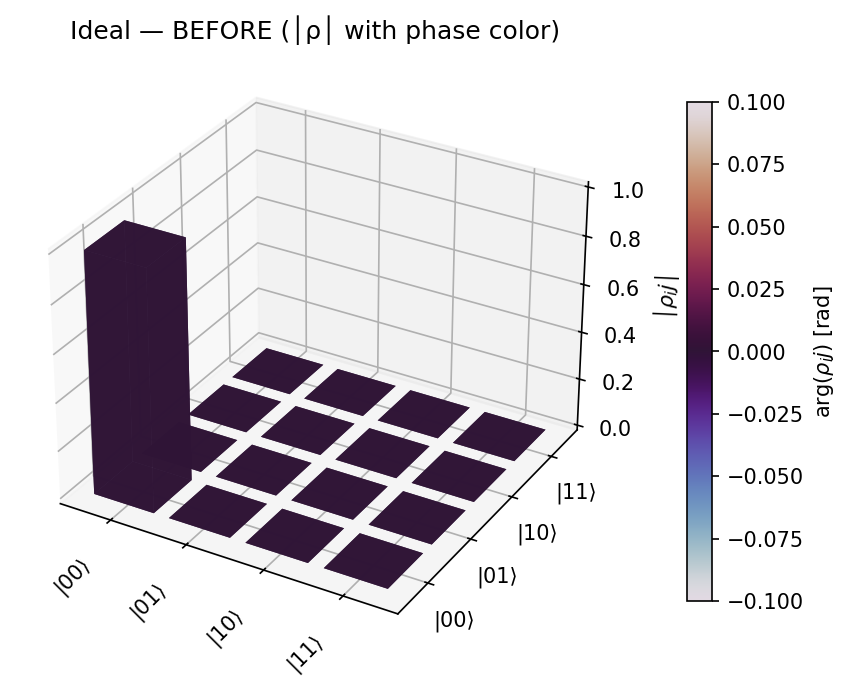

/tmp/ipython-input-525786896.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda z: f"{z.real:+.4f}{z.imag:+.4f}i")


=== Ideal (no noise) — AFTER (numeric density matrix) ===


|00⟩             |01⟩             |10⟩             |11⟩
|00⟩  +0.0000+0.0000i  +0.0000+0.0000i  -0.0000+0.0000i  +0.0000-0.0000i
|01⟩  +0.0000+0.0000i  +0.0000+0.0000i  -0.0000+0.0000i  +0.0000-0.0000i
|10⟩  -0.0000+0.0000i  -0.0000+0.0000i  +0.8853+0.0000i  -0.0160+0.3183i
|11⟩  +0.0000+0.0000i  +0.0000+0.0000i  -0.0160-0.3183i  +0.1147+0.0000i

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


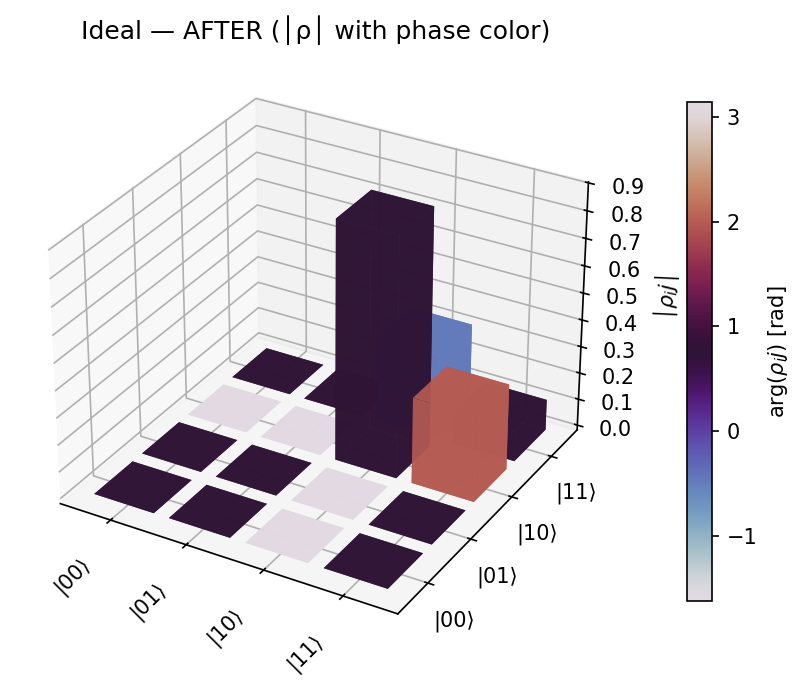

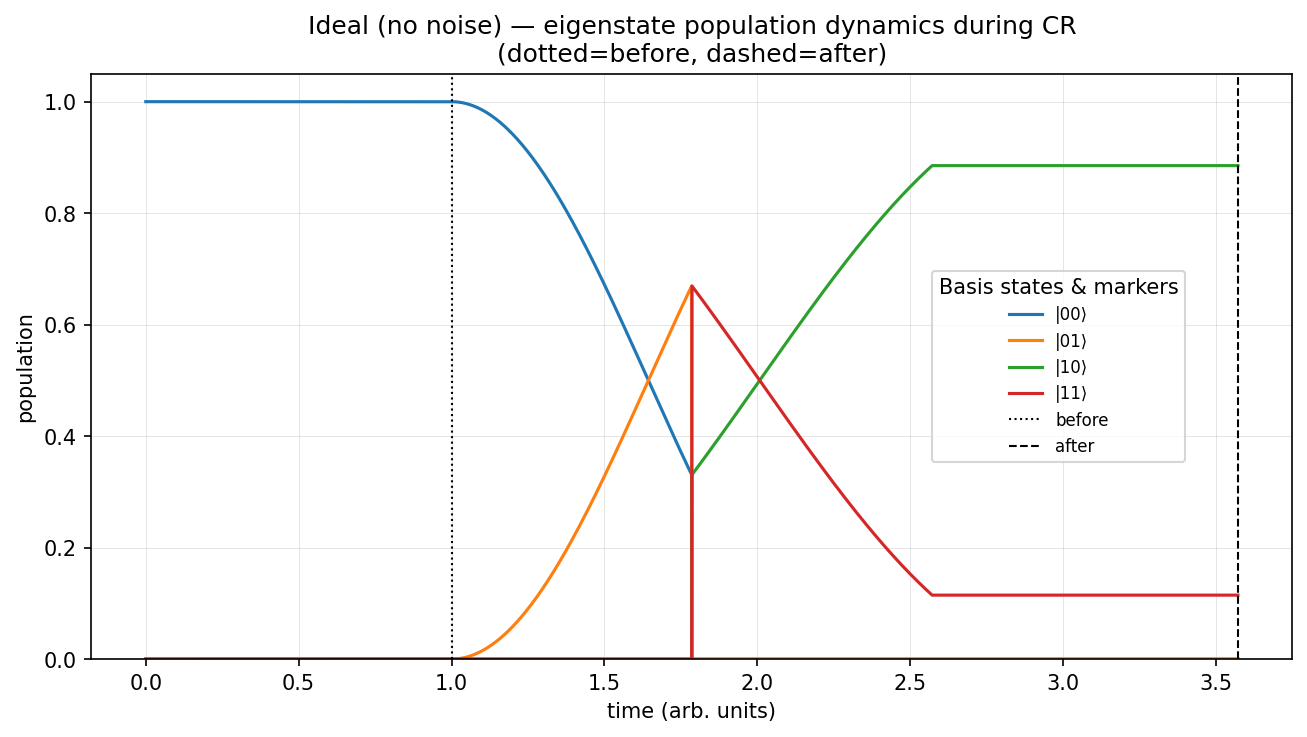

In [61]:
#@title 8′) Ideal qubit reference — density matrices & eigenstate populations (no noise)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import qutip as qt

# --- Pull ideal snapshots from your existing run ---
times = np.asarray(sim["times"])
idx_before = int(sim["idx_before"])
idx_after  = int(sim["idx_after"])
rho_before_ideal = qt.ket2dm(sim["states"][idx_before])
rho_after_ideal  = qt.ket2dm(sim["states"][idx_after])

# --- Basis labels (if not already defined) ---
try:
    labels
except NameError:
    labels = ["|00⟩","|01⟩","|10⟩","|11⟩"]

# --- Minimal helpers (use existing if available) ---
def _dm_table(rho):
    df = pd.DataFrame(rho.full(), index=labels, columns=labels)
    return df.applymap(lambda z: f"{z.real:+.4f}{z.imag:+.4f}i")

def _plot_dm_3d(rho, title):
    M = rho.full()
    mag = np.abs(M); phase = np.angle(M)
    nx, ny = M.shape
    xpos, ypos = np.meshgrid(np.arange(ny), np.arange(nx))
    xpos = xpos.ravel(); ypos = ypos.ravel()
    zpos = np.zeros_like(xpos); dx = dy = 0.8*np.ones_like(zpos)
    dz = mag.ravel()

    cmap = plt.get_cmap("twilight")  # phase-only, perceptually uniform around 2π
    colors = cmap((phase.ravel() + np.pi) / (2.0*np.pi))  # map −π..π → 0..1

    # Keep this plot's colorbar; there is no legend here.
    fig = plt.figure(figsize=(6.8, 5.4), layout="constrained")
    ax = fig.add_subplot(111, projection="3d")
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=False, color=colors, alpha=0.9)
    ax.set_xticks(np.arange(ny)+0.4); ax.set_yticks(np.arange(nx)+0.4)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_zlabel("│$ρ_ij$│")
    ax.set_title(title)
    m = plt.cm.ScalarMappable(cmap=cmap); m.set_array(phase)
    # colorbar (not a legend) remains attached; pad is modest so the bars have room
    cbar = fig.colorbar(m, ax=ax, shrink=0.80, pad=0.09)
    cbar.set_label("arg($ρ_ij$) [rad]")
    plt.show()

def _populations_from_rho(rho):
    return np.real(np.diag(rho.full())).ravel()

# --- Show the ideal density matrices BEFORE and AFTER ---
print("=== Ideal (no noise) — BEFORE (numeric density matrix) ===")
display(_dm_table(rho_before_ideal))
__ = _plot_dm_3d(rho_before_ideal, "Ideal — BEFORE (│ρ│ with phase color)")

print("=== Ideal (no noise) — AFTER (numeric density matrix) ===")
display(_dm_table(rho_after_ideal))
__ = _plot_dm_3d(rho_after_ideal, "Ideal — AFTER (│ρ│ with phase color)")

# --- Ideal population dynamics over the whole CR sequence ---
pops_ideal = np.array([_populations_from_rho(qt.ket2dm(psi)) for psi in sim["states"]])  # (T,4)

# Use layout='constrained' so an outside legend gets proper space
fig, ax = plt.subplots(figsize=(8.6, 4.8), layout="constrained")
for k, lab in enumerate(labels):
    ax.plot(times, pops_ideal[:, k], label=lab)

# Mark the 'before' and 'after' snapshot times
ax.axvline(times[idx_before], color="k", linestyle=":",  linewidth=1.0, label="before")
ax.axvline(times[idx_after],  color="k", linestyle="--", linewidth=1.0, label="after")

ax.set_xlabel("time (arb. units)")
ax.set_ylabel("population")
ax.set_title("Ideal (no noise) — eigenstate population dynamics during CR\n(dotted=before, dashed=after)")

# Move the legend further right of the Axes
# Notes:
#   • loc='center left' pins the legend's left-center to the anchor point.
#   • bbox_to_anchor=(x, y) uses Axes coords; increase x>1.0 to push farther right.
leg = ax.legend(
    loc="center left",
    bbox_to_anchor=(0.7, 0.5),   # try 1.10–1.20 as needed for your layout
    fontsize=8,
    frameon=True,
    title="Basis states & markers",
    borderaxespad=0.0
)

ax.grid(True, linewidth=0.45, alpha=0.35)
ax.set_ylim(0.0, 1.05)
plt.show()

In [64]:
#@title 8) Sanity checks on reduced states
def check_density(rho):
    mat = rho.full()
    tr = float(np.trace(mat))
    herm_ok = np.allclose(mat, mat.conj().T, atol=1e-10)
    evals = np.linalg.eigvalsh(mat)
    min_eval = float(np.min(evals))
    return tr, herm_ok, min_eval

for tag, rho2 in snapshots.items():
    rho_c, rho_t = reduced_qubit_states(rho2)
    tr_c, herm_c, min_c = check_density(rho_c)
    tr_t, herm_t, min_t = check_density(rho_t)
    print(f"{tag} — Control: trace={tr_c:.12f}, Hermitian={herm_c}, min_eig={min_c:.3e}")
    print(f"{tag} — Target : trace={tr_t:.12f}, Hermitian={herm_t}, min_eig={min_t:.3e}")


Before (idle) — Control: trace=1.000000000000, Hermitian=True, min_eig=0.000e+00
Before (idle) — Target : trace=1.000000000000, Hermitian=True, min_eig=0.000e+00
During (mid-gate) — Control: trace=1.000000000000, Hermitian=True, min_eig=0.000e+00
During (mid-gate) — Target : trace=1.000000000000, Hermitian=True, min_eig=-1.388e-16
After (idle) — Control: trace=1.000000000000, Hermitian=True, min_eig=0.000e+00
After (idle) — Target : trace=1.000000000000, Hermitian=True, min_eig=-4.163e-17


/tmp/ipython-input-1421915444.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  tr = float(np.trace(mat))
